In [ ]:
! pip install nltk
! pip install stemming
! pip install numpy
! pip install pandas
! pip install networkx
! pip install matplotlib
! pip install scipy

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Import essential packages

In [2]:
import glob
import random
import re
import nltk
from stemming.porter2 import stem
from nltk.corpus import stopwords
import string
import numpy as np
import pandas as pd
import csv
import networkx as nx
from matplotlib import pylab
from matplotlib import pyplot as plt
import scipy.sparse

### Import amazon co-purchased product meta data file

In [3]:
# Loading the datafile
filename="amazon-meta.txt"
text = open(filename,'r',encoding='utf-8',errors='ignore')

#### Data Preprocessing

In [4]:
# Initialize a dictionary to store Amazon product information
amazon = {}

# Define a tuple to hold product attributes
(attributes, product_id, product_title, category_list, product_group, related_products, ranking, review_count, average_rating, centrality_score, clustering_value) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)

# Process each line in the provided text data
for line in text:
    line = line.strip()

    # Extract various product attributes from the text
    if line.startswith("Id"):
        product_id = line[3:].strip()
    elif line.startswith("ASIN"):
        attributes = line[5:].strip()
    elif line.startswith("title"):
        product_title = ' '.join(line[6:].strip().split())
    elif line.startswith("group"):
        product_group = line[6:].strip()
    elif line.startswith("salesrank"):
        ranking = line[10:].strip()
    elif line.startswith("similar"):
        related_products = ' '.join(line.split()[2:])
    elif line.startswith("categories"):
        num_categories = int(line.split()[1].strip())
        category_list = ' '.join((text.readline()).lower() for _ in range(num_categories))
        category_list = re.sub('[%s]' % re.escape(string.digits + string.punctuation), ' ', category_list)
        category_list = ' '.join(set(category_list.split()) - set(stopwords.words('english')))
        category_list = ' '.join(stem(word) for word in category_list.split())
    elif line.startswith("reviews"):
        review_data = line.split()
        review_count = review_data[2].strip()
        average_rating = review_data[7].strip()
    elif line == "":
        try:
            if attributes:
                product_entry = {
                    'Id': product_id,
                    'title': product_title,
                    'group': product_group,
                    'categories': ' '.join(set(category_list.split())),
                    'connections': related_products,
                    'salesrank': int(ranking),
                    'tot_reviews': int(review_count),
                    'avg_rating': float(average_rating),
                    'degree_centrality': centrality_score,
                    'clustering_coeff': clustering_value
                }
                amazon[attributes] = product_entry
        except NameError:
            continue
        # Reset the tuple for the next product entry
        (attributes, product_id, product_title, category_list, product_group, related_products, ranking, review_count, average_rating, centrality_score, clustering_value) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)

# Close the text data source
text.close()

In [5]:
#Creating the dataframe of the amazon metadata after preprocessing
amazon_df = pd.DataFrame.from_dict(amazon)
amazon_df = amazon_df.transpose()

In [6]:
amazon_df.head()

Id                                              title group  \
0771044445  0                                                            
0827229534  1            Patterns of Preaching: A Sermon Sampler  Book   
0738700797  2                         Candlemas: Feast of Flames  Book   
0486287785  3   World War II Allied Fighter Planes Trading Cards  Book   
0842328327  4  Life Application Bible Commentary: 1 and 2 Tim...  Book   

                                                   categories  \
0771044445                                                      
0827229534  book preach religion clergi spiritu sermon sub...   
0738700797  book base religion wicca earth spiritu subject...   
0486287785       book general hobbi craft home subject garden   
0842328327  general religion translat commentari studi tex...   

                                                  connections salesrank  \
0771044445                                                            0   
0827229534  0804215715 156101074X 0687023955 0687074231 08...    396585   
0738700797  0738700827 1567184960 1567182836 0738700525 07...    168596   
0486287785                                                      1270652   
0842328327  0842328130 0830818138 0842330313 0842328610 08...    631289   

           tot_reviews avg_rating degree_centrality clustering_coeff  
0771044445           0        0.0                 0              0.0  
0827229534           2        5.0                 0              0.0  
0738700797          12        4.5                 0              0.0  
0486287785           1        5.0                 0              0.0  
0842328327           1        4.0                 0              0.0

In [7]:
len(amazon_df)

548552

In [8]:
amazon_df.to_csv('amazon_data.csv', encoding='utf-8', index=False)

#### Creating subset of data belonging to DVD group for further network analysis

For further analysis and identifying of centrality metrics, only DVD subgroup - 19,828 products are considered as the full product network is very huge - 548,552 products which is computationally costly.

In [9]:
# Subset of DVDs
amazon_dvd = {}
for key, value in amazon.items():
    if(value['group'] == "DVD"):
        amazon_dvd[key] = amazon[key]

for key, value in amazon_dvd.items():
    amazon_dvd[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in amazon_dvd.keys()])

amazon_dvd_df = pd.DataFrame.from_dict(amazon_dvd)
amazon_dvd_df = amazon_dvd_df.transpose()

In [10]:
amazon_dvd_df.to_csv('DVD_data.csv', encoding='utf-8', index=False)

In [11]:
amazon_dvd_df.head()

Id                                     title group  \
0790747324   21                          The Time Machine   DVD   
B000056PNC   37  Mark Messier - Leader, Champion & Legend   DVD   
B000056PNB   42                                    Pixote   DVD   
B000056PNE   44              The NBA's 100 Greatest Plays   DVD   
B00000IC80  149           Pot O' Gold/Made for Each Other   DVD   

                                                   categories  \
0790747324  video general p taylor time whit dori yvett fa...   
B000056PNC  general hockey dvd featur genr sport special t...   
B000056PNB  general hector p b age cinema brazil portugues...   
B000056PNE  general store dvd com featur genr amazon outle...   
B00000IC80  general g p gordon comedi h b winning categori...   

                                                  connections salesrank  \
0790747324  B00007JMD8 6305350221 B00004RF9B B00005JKFR B0...       795   
B000056PNC                                                        46018   
B000056PNB                              B00004TJRE B00006LPHE     19685   
B000056PNE                                                        33124   
B00000IC80                                         B00006AUGQ     51310   

           tot_reviews avg_rating degree_centrality clustering_coeff  
0790747324         140        4.5                 0              0.0  
B000056PNC           7        3.5                 0              0.0  
B000056PNB          24        4.5                 0              0.0  
B000056PNE          13        4.0                 0              0.0  
B00000IC80           0        0.0                 0              0.0

In [12]:
len(amazon_dvd_df)

19828

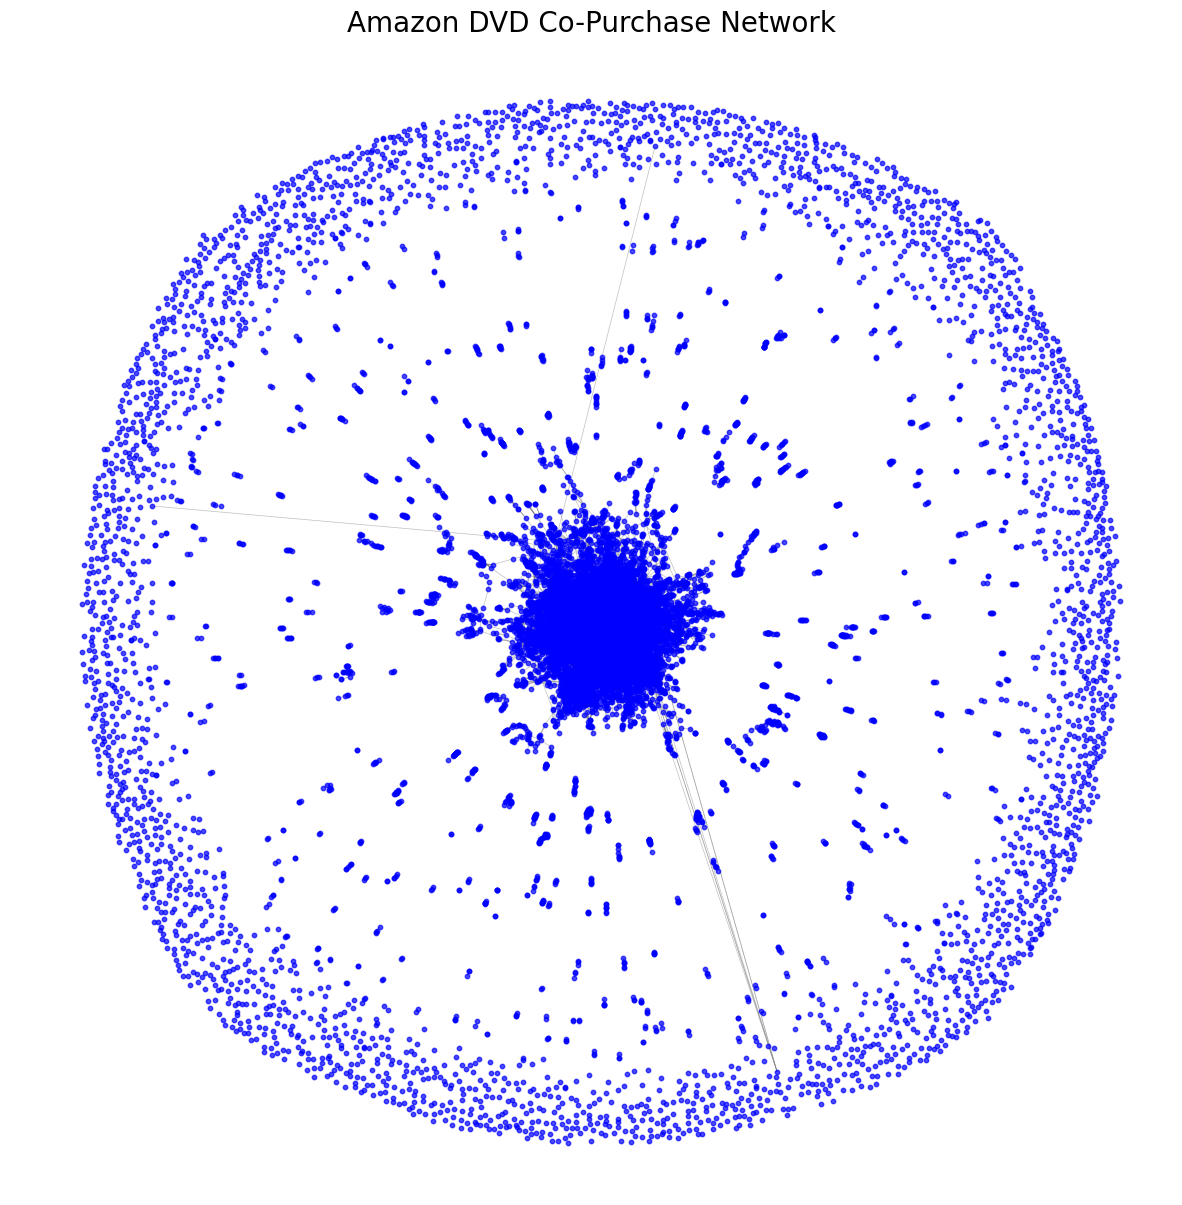

In [13]:
G = nx.Graph()

# Add nodes and edges with weights
for key, value in amazon_dvd.items():
    G.add_node(key)
    for i in value['connections'].split():
        G.add_node(i.strip())
        similarity = 0
        try:
            set_1 = set(amazon_dvd[key]['categories'].split())
            set_2 = set(amazon_dvd[i]['categories'].split())
        except KeyError:
            continue
        union = set_1 & set_2
        intersection = set_1 | set_2
        if len(union) > 0:
            similarity = round(len(intersection)/len(union), 2)
        G.add_edge(key, i.strip(), weight=similarity)

# Fruchterman-Reingold force-directed layout
pos = nx.fruchterman_reingold_layout(G)

# Plot settings
plt.figure(figsize=(15, 15))  # Increase figure size for better visibility
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', alpha=0.7)  # Customize node appearance
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='grey')  # Customize edge appearance

# Optional: Labels for nodes (might be too cluttered for large graphs)
# nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

plt.title('Amazon DVD Co-Purchase Network', fontsize=20)  # Add a title to the plot
plt.axis('off')  # Turn off the axis
plt.show()

In [14]:
# Transformation of DVD data into graph
G = nx.Graph()
for key, value in amazon_dvd.items():
    G.add_node(key)
    for i in value['connections'].split():
        G.add_node(i.strip())
        similarity = 0
        try:
            set_1 = set(amazon_dvd[key]['categories'].split())
            set_2 = set(amazon_dvd[i]['categories'].split())
        except KeyError:
            continue
        union = set_1 & set_2
        intersection = set_1 | set_2
        if(len(union)) > 0:
            similarity = round(len(intersection)/len(union),2)
        G.add_edge(key, i.strip(), weight=similarity)

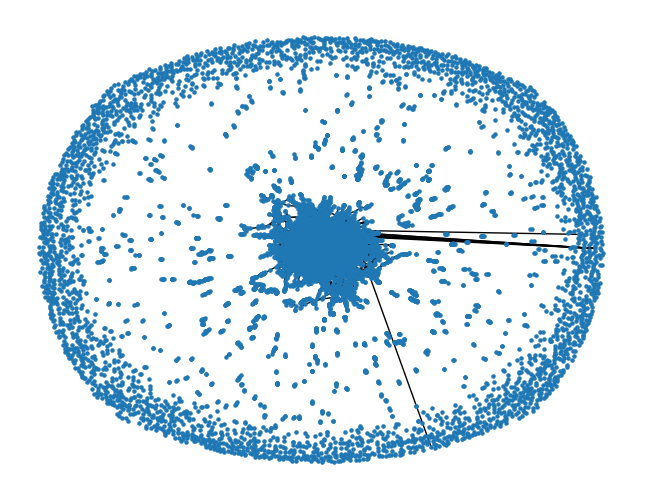

In [57]:
pos=nx.spring_layout(G)
nx.draw(G,pos,node_size=5, width=1)

### Cliques

In [58]:
cliques = list(nx.find_cliques(G))
print('Number of cliques:', len(cliques))

Number of cliques: 23428


### Centrality metrics

In [59]:
def print_centrality(centrality, name):
    result = pd.DataFrame(centrality.items(), columns=['ASIN', name])
    result.sort_values(name, ascending=False, inplace=True)
    print(result.to_records(index=False).tolist())
    result.hist()
    return result

In [60]:
def plot_centrality(centrality,G):
    plt.figure(figsize=(10, 5))
    node_color = [centrality[i] for i in centrality.keys()]

    cmap = plt.cm.ScalarMappable(
        cmap = 'Wistia', 
        norm = plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
    cmap.set_array([])
    plt.colorbar(cmap)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap='Wistia', node_size = 35)
    nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.2)
    #nx.draw_networkx_labels(G, pos, font_size=4)
    plt.show()

#### Degree centrality of the DVD subgroup network

[('B00008LDNZ', 247), ('B00005R1O7', 80), ('B00005U128', 78), ('B00005ATZT', 58), ('B00007ELED', 55), ('B0000541AK', 54), ('B000068DBC', 51), ('6305014140', 51), ('B00008L3MH', 51), ('B00005OW09', 48), ('B000063K1Q', 47), ('6305078629', 47), ('B00008RH3Y', 45), ('6304493681', 44), ('157362408X', 43), ('630469623X', 40), ('B000063UR0', 40), ('B00005JLG1', 40), ('6304765266', 37), ('B00008975Z', 37), ('B00005V3Z4', 35), ('B00004TJS2', 35), ('B00004RF3O', 34), ('0790731479', 34), ('B00005R1N3', 34), ('0790729628', 34), ('6305807957', 34), ('B000022TSH', 33), ('B00005N5S5', 33), ('B00000IBWR', 33), ('B0000639E0', 33), ('B0000507OK', 32), ('B00005QW5T', 31), ('6304711891', 31), ('B00005JM6H', 31), ('B000059H8T', 30), ('B000059HB7', 30), ('6305976333', 30), ('6304711913', 29), ('6305972052', 29), ('B00006FDCF', 29), ('6305511705', 29), ('6305505780', 29), ('B00004STT7', 29), ('B00001QEE7', 28), ('0780622553', 28), ('B00003CXAT', 28), ('B000069CF0', 28), ('B00002RAPT', 28), ('B00003W8NS', 27)

ASIN  Degree Centrality
271    B00008LDNZ                247
988    B00005R1O7                 80
180    B00005U128                 78
634    B00005ATZT                 58
1076   B00007ELED                 55
...           ...                ...
7798   B00006JDU9                  0
3648   B00004Z4T4                  0
13975  B000089Q6N                  0
17358  B00005QAPM                  0
19827  B00008DDST                  0

[19828 rows x 2 columns]

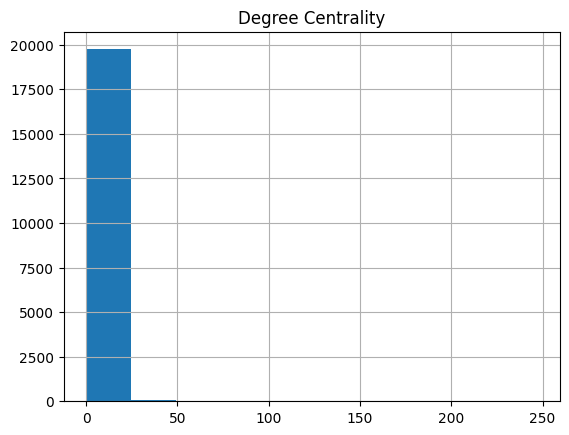

In [61]:
degree = dict(nx.degree(G))
print_centrality(degree, 'Degree Centrality')

#### Betweenness centrality of the DVD network

[('B00008LDNZ', 0.09238256225630352), ('B00007ELED', 0.022008924946468732), ('B00000IREA', 0.020843943219820596), ('B00006G8FS', 0.01748556439491906), ('6305262268', 0.016859570565977738), ('6305078629', 0.014004807057772413), ('B00005OW09', 0.013658984314119793), ('B00005U2KC', 0.013433510101979849), ('B00000I21X', 0.013407277478939852), ('B0000648YJ', 0.013078968466071924), ('B00003CXCZ', 0.011740635053805858), ('B00005ATZT', 0.011705294751344035), ('6305310351', 0.011512679417689901), ('B00003CXBK', 0.011479171109785738), ('6305014140', 0.01129456960877361), ('B00004YRJT', 0.011092637848463028), ('B00006LPEX', 0.010963242570105709), ('B00005QW4F', 0.010952980694964509), ('B00006FD8V', 0.010770790381326183), ('B000063UR5', 0.010551116301488016), ('6305428476', 0.01040954857758272), ('B00003CXDS', 0.01012200667885656), ('B00005U128', 0.010077425732428617), ('0738920533', 0.010077154366229519), ('B00005V3Z4', 0.009939850592030317), ('6304498969', 0.009927083090189248), ('B00005R1O7', 0

ASIN  Betweenness Centrality
271    B00008LDNZ                0.092383
1076   B00007ELED                0.022009
4826   B00000IREA                0.020844
19483  B00006G8FS                0.017486
528    6305262268                0.016860
...           ...                     ...
12882  B000051S7A                0.000000
2962   B000056IQJ                0.000000
12871  B0000522IA                0.000000
12870  B0000687EU                0.000000
19827  B00008DDST                0.000000

[19828 rows x 2 columns]

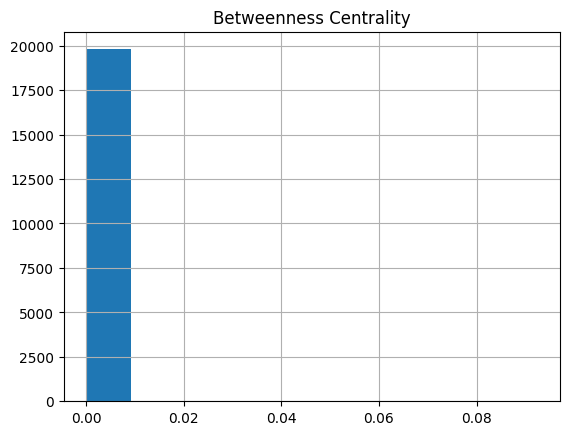

In [62]:
betweenness = nx.betweenness_centrality(G)
print_centrality(betweenness, 'Betweenness Centrality')

#### Closeness centrality of the DVD network

[('B00008LDNZ', 0.11806553286537448), ('B00005U2KC', 0.11008722949955564), ('B000063UR5', 0.10950907882779239), ('B00005ATZT', 0.10914854107021425), ('6305262268', 0.10831830882312009), ('6305511055', 0.10792010019352419), ('B000022TSH', 0.10791123511839713), ('B00007ELED', 0.10767353056171446), ('0780622553', 0.1072275000198508), ('0767817761', 0.10669300085223071), ('0780621611', 0.10633459752254389), ('B00005V3Z4', 0.10624537260853228), ('6305999872', 0.10603847558693538), ('0790729628', 0.1060341960887631), ('B00000IREA', 0.10589423317223791), ('B00008OE4W', 0.10580361502628213), ('B00006RCO1', 0.10565151275681174), ('0792846133', 0.10554858718020245), ('0792841395', 0.1052051902711432), ('0792833287', 0.10509367276945579), ('1573623768', 0.10509157093803702), ('0767818083', 0.10509052005385418), ('B00000K3C6', 0.10504745189062391), ('B000068DBC', 0.10504430194754044), ('B00005OCK7', 0.10499497749061461), ('B000089791', 0.10493207737030551), ('0767827678', 0.10489332651581058), ('B

ASIN  Closeness Centrality
271    B00008LDNZ              0.118066
4829   B00005U2KC              0.110087
1575   B000063UR5              0.109509
634    B00005ATZT              0.109149
528    6305262268              0.108318
...           ...                   ...
15117  B00005JXYQ              0.000000
15124  B00005LC5T              0.000000
15125  B00005LC59              0.000000
15128  B00005JXY0              0.000000
19827  B00008DDST              0.000000

[19828 rows x 2 columns]

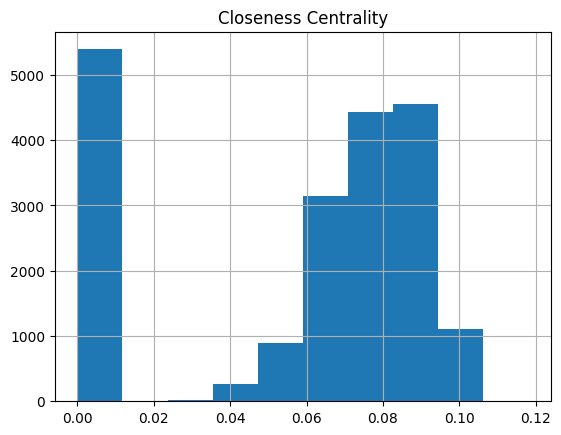

In [63]:
closeness = nx.closeness_centrality(G)
print_centrality(closeness, 'Closeness Centrality')

#### Eigen vector centrality of the DVD network

[('B00008LDNZ', 0.689626921840009), ('6305999872', 0.0689767619618373), ('B00006RCO1', 0.0652711011683436), ('B00004W229', 0.06117114335195401), ('B00007G1ZM', 0.05941135259509638), ('B000055Y14', 0.057662371771832754), ('B000063K2W', 0.05763009811036374), ('B00004XQMY', 0.0568986365851462), ('B00004XQN4', 0.05647388515162325), ('B000035P5R', 0.05466420037147069), ('B00006SFJ5', 0.05425741625367057), ('B00005JL0W', 0.053597221588063494), ('B00005EBSE', 0.05336099568832663), ('B00006SFJ8', 0.053228443897891005), ('0792846133', 0.05313602848421869), ('B00000IPHT', 0.05301249035102181), ('B00005AUK9', 0.052897582666029806), ('6305914842', 0.052548946721163226), ('B000059LGF', 0.05235667916647919), ('B00005JH9B', 0.0522769520487189), ('B00004RER5', 0.05216723379074038), ('B000063URD', 0.05096490047628555), ('B00005LC4D', 0.0507466376332606), ('B00005AUKD', 0.0503639052204829), ('B00005RDRL', 0.05013134866017626), ('B00004TX2E', 0.05005633109666006), ('0780023420', 0.05000261126973716), ('B

ASIN  Eigenvector Centrality
271    B00008LDNZ            6.896269e-01
1591   6305999872            6.897676e-02
4105   B00006RCO1            6.527110e-02
1592   B00004W229            6.117114e-02
6171   B00007G1ZM            5.941135e-02
...           ...                     ...
17514  B00006G8IN            2.464875e-51
14050  B00005U8E7            2.464875e-51
14048  B00005U8E8            2.464875e-51
17517  B00005QIVR            2.464875e-51
19827  B00008DDST            2.464875e-51

[19828 rows x 2 columns]

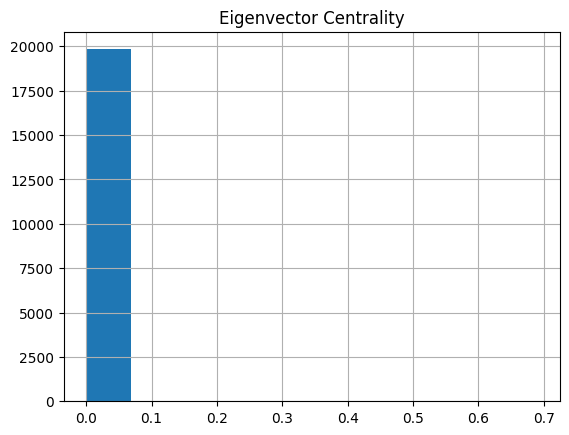

In [64]:
eigenvector = nx.eigenvector_centrality(G)
print_centrality(eigenvector, 'Eigenvector Centrality')

## Calculating the centrality metrics for each category of DVD's


#### There are different categories like horror, comedy, documentary, kids, drama, anime, action, mystery, music and science. Some DVD's belong to multiple categories.

### Centrality merics for DVD category:Horror

In [65]:
df_horror = amazon_dvd_df[amazon_dvd_df['categories'].str.contains('horror')]
len(df_horror)

1590

In [66]:
dvd_horror = {}
for key, value in amazon_dvd.items():
    if('horror' in (value['categories'])):
        dvd_horror[key] = amazon_dvd[key]

for key, value in dvd_horror.items():
    dvd_horror[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in dvd_horror.keys()])

In [67]:
amazon_dvdhorror_df = pd.DataFrame.from_dict(dvd_horror)
amazon_dvdhorror_df = amazon_dvdhorror_df.transpose()


In [68]:
amazon_dvdhorror_df.head()

Id        ASIN                               title group  \
B00005O438  1504  B00005O438                                Cujo   DVD   
B00008WJDA  1625  B00008WJDA                         The Crazies   DVD   
B00005NB9E  1670  B00005NB9E                     Graveyard Shift   DVD   
B00008WJD9  1684  B00008WJD9                       Two Evil Eyes   DVD   
6305334854  1898  6305334854  Deadbeat at Dawn (Special Edition)   DVD   

                                                   categories  \
B00005O438  k hardin director general store featur suspens...   
B00008WJDA  fantasi blue romero georg director general sto...   
B00005NB9E  art studio theme manga media go general featur...   
B00008WJD9  balsam art k blue hunter romero georg director...   
6305334854  mayhem theme crime action general store featur...   

                                                  connections salesrank  \
B00005O438  B00004W5UF 0767827716 B00006FDCU B00005K3NR B0...     15006   
B00008WJDA                   B00005U128 6305972052 0792841336     17812   
B00005NB9E                                         B00005KA70     45274   
B00008WJD9  B00005LQ06 6305807957 B00000IBRI B00005LQ04 63...     17726   
6305334854                                         B0000687C6     30196   

           tot_reviews avg_rating  
B00005O438           0        0.0  
B00008WJDA           0        0.0  
B00005NB9E           0        0.0  
B00008WJD9           0        0.0  
6305334854           0        0.0

In [69]:
# Transformation of horror category of DVD data into graph
G1 = nx.Graph()
for key, value in dvd_horror.items():
    G1.add_node(key)
    for i in value['connections'].split():
        G1.add_node(i.strip())
        similarity = 0
        try:
            set_1 = set(dvd_horror[key]['categories'].split())
            set_2 = set(dvd_horror[i]['categories'].split())
        except KeyError:
            continue
        union = set_1 & set_2
        intersection = set_1 | set_2
        if(len(union)) > 0:
            similarity = round(len(intersection)/len(union),2)
        G1.add_edge(key, i.strip(), weight=similarity)

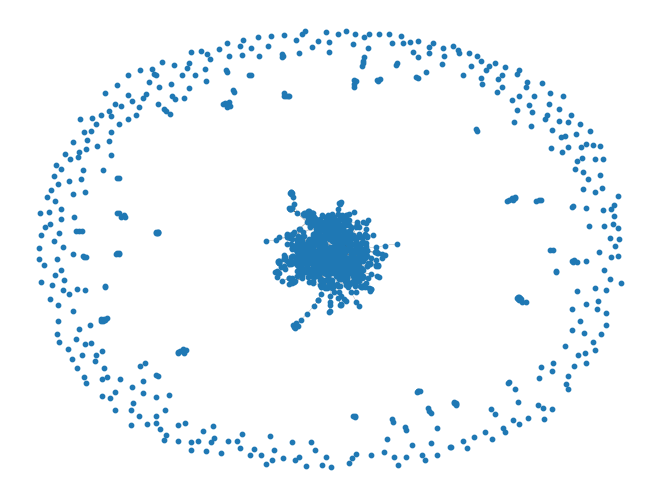

In [70]:
pos=nx.spring_layout(G1)
nx.draw(G1,pos,node_size=10, width=0.1)

[('B00005U128', 72), ('157362408X', 39), ('6305807957', 33), ('B00005R1N3', 31), ('6305972052', 29), ('1573471046', 24), ('B00006FDCU', 23), ('6305596247', 22), ('B00008QSB4', 22), ('B00004W5UF', 21), ('B00002NDM3', 20), ('B00005KHJS', 20), ('1573623911', 20), ('6305807930', 19), ('6305588236', 19), ('1573624098', 17), ('B00004Y632', 17), ('B00005LQ04', 17), ('B000067FP3', 17), ('1573470473', 17), ('6305942986', 17), ('6304936397', 17), ('B000063URC', 16), ('6305840024', 16), ('B00005LC4Q', 16), ('0792833201', 16), ('B00004W20F', 16), ('B00004Z1G1', 16), ('6305291446', 15), ('B00005OKQF', 15), ('6305972001', 15), ('B00000IBRI', 15), ('B00005Q4DS', 15), ('B00005R24H', 15), ('B00000K3U3', 15), ('1573625779', 14), ('B00005KHJP', 14), ('B00005ATQJ', 14), ('B00005LQ06', 14), ('B00006ADFZ', 14), ('6305608288', 13), ('B0000524CY', 13), ('6305976414', 13), ('B00005NG6C', 13), ('B00005ASOD', 13), ('6305841861', 13), ('0783116926', 13), ('B00006FDCD', 13), ('B00000JT2R', 13), ('B00000K3TO', 13),

ASIN  Degree Centrality
7     B00005U128                 72
141   157362408X                 39
14    6305807957                 33
137   B00005R1N3                 31
8     6305972052                 29
...          ...                ...
1041  B00006HAWZ                  0
1039  B00005V9I1                  0
1038  B00005V9IC                  0
1023  0767844335                  0
1589  B000059TOC                  0

[1590 rows x 2 columns]

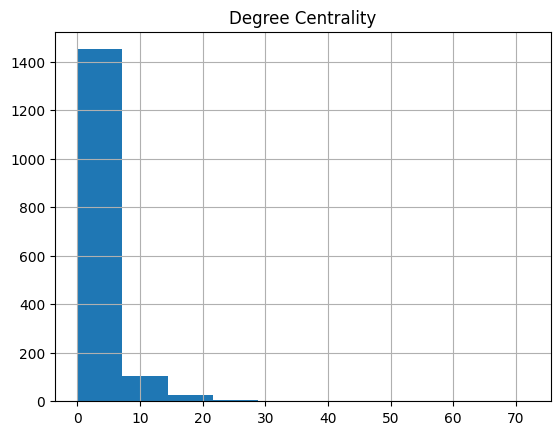

In [71]:
#Degree Centrality
degree = dict(nx.degree(G1))
print_centrality(degree, 'Degree Centrality')

In [101]:

def plot_centrality(centrality, G):
    # Create a figure and an Axes object
    fig, ax = plt.subplots(figsize=(10, 8))
    pos = nx.spring_layout(G)

    # Normalization and node color based on centrality
    norm = plt.Normalize(vmin=min(centrality.values()), vmax=max(centrality.values()))
    node_color = [centrality[n] for n in G.nodes()]

    # Draw the graph
    nx.draw(G, pos, ax=ax, with_labels=False, node_color=node_color, cmap='Wistia', node_size=35)

    # Create a ScalarMappable with the normalization and colormap
    sm = plt.cm.ScalarMappable(cmap='Wistia', norm=norm)
    sm.set_array([])  # Set a dummy array for ScalarMappable
    plt.figure(figsize=(500,500))
    # Create a colorbar associated with the Axes
    fig.colorbar(sm, ax=ax)

    plt.show()


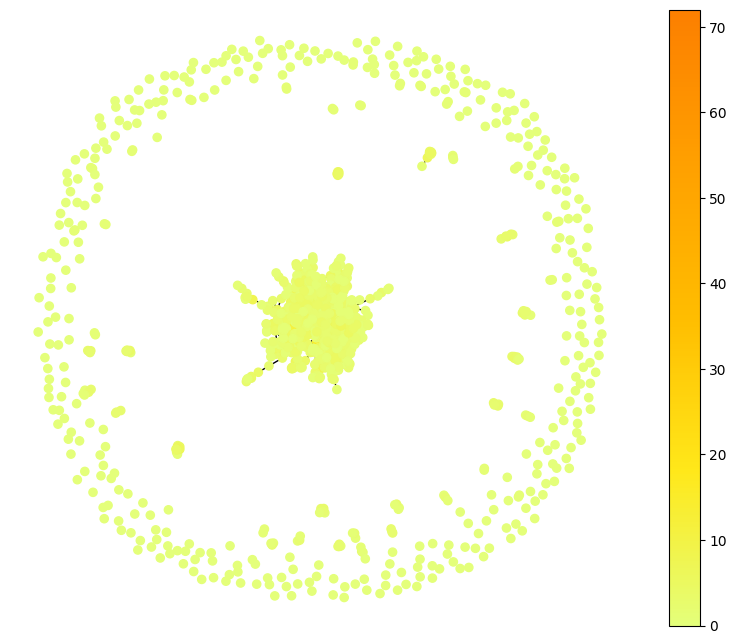

<Figure size 50000x50000 with 0 Axes>

In [97]:
plot_centrality(degree, G1)

[('B00005U128', 0.12471794462067637), ('B00005R1N3', 0.07699996025623221), ('0792833201', 0.06014891221917298), ('157362408X', 0.044759012393369525), ('B00005KHJS', 0.039034736261417555), ('6305596247', 0.03729471595186352), ('B000067FP3', 0.02753880363357267), ('B00007M5IW', 0.026110030211494283), ('6305951454', 0.026058423729370523), ('1573471046', 0.025876114929440152), ('B00000IO3W', 0.025869409531692974), ('1573470473', 0.025092255569461912), ('B000063URC', 0.024605187400112735), ('B00005LIRD', 0.023130519248648077), ('B00004W20F', 0.02260018575890714), ('6305951446', 0.021451187996929185), ('0800177177', 0.021443018416762903), ('B0000639EK', 0.021111706775115743), ('0783116926', 0.0208639649098693), ('0782009980', 0.019266580977474176), ('0767817664', 0.01922763730622606), ('0783232101', 0.01857982229818736), ('6305807957', 0.016980050864119703), ('B00008QSB4', 0.01678807571495092), ('B00002NDM3', 0.016711432110120307), ('B00005KHJL', 0.016655574654076313), ('B00000K3U3', 0.01601

ASIN  Betweenness Centrality
7     B00005U128                0.124718
137   B00005R1N3                0.077000
209   0792833201                0.060149
141   157362408X                0.044759
227   B00005KHJS                0.039035
...          ...                     ...
870   B00004WL4R                0.000000
874   B000056NW7                0.000000
875   6305090599                0.000000
882   B00005U4UV                0.000000
1589  B000059TOC                0.000000

[1590 rows x 2 columns]

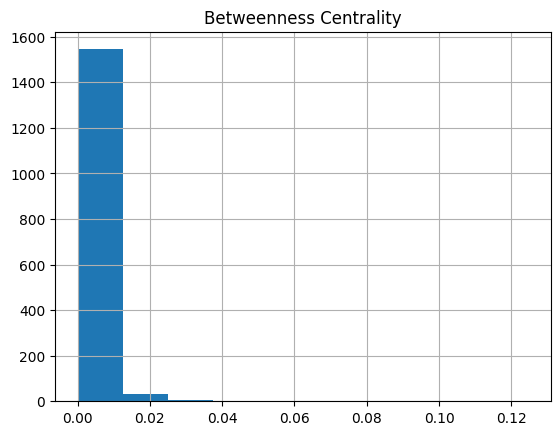

In [91]:
#Betweenness centrality
betweenness = nx.betweenness_centrality(G1)
print_centrality(betweenness, 'Betweenness Centrality')

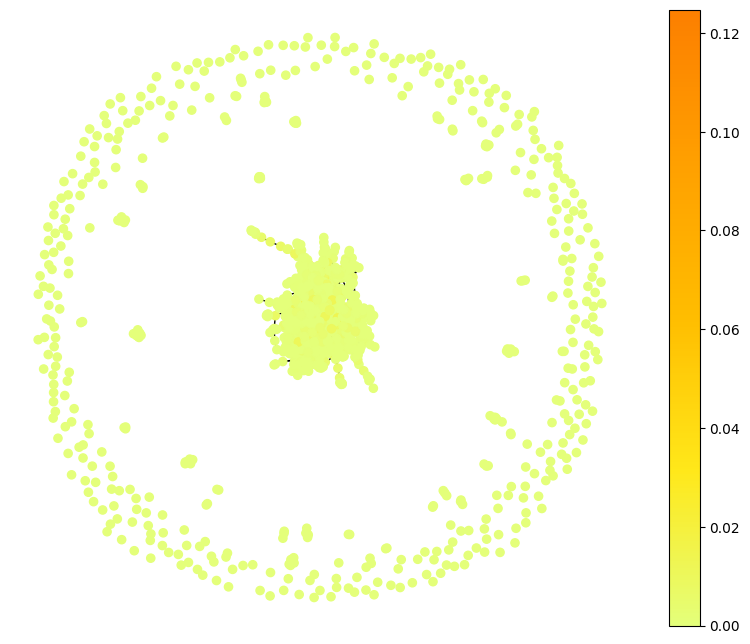

<Figure size 50000x50000 with 0 Axes>

In [92]:
plot_centrality(betweenness, G1)

[('B00005U128', 0.15907106050590142), ('B00005R1N3', 0.15484304213220132), ('B00005KHJS', 0.14852663641274694), ('157362408X', 0.14717009698184932), ('6305972052', 0.14558579759104126), ('B00000JXVR', 0.14530646950663786), ('1573471046', 0.1445300227230146), ('B00005ASOH', 0.14235663892266853), ('B00005IAQA', 0.14235663892266853), ('B00000IO3R', 0.14132064173700254), ('B00004W3H8', 0.141241573865833), ('B00005KHJU', 0.14110999051026582), ('0783116926', 0.14076901841423728), ('B00005RYLB', 0.14016977957960328), ('B00005V9HA', 0.14009199390836044), ('B000059PPN', 0.13952419290136267), ('B00005R24H', 0.13919083239636032), ('B00006FMBT', 0.13885906106868293), ('B000068TPD', 0.13883360569543476), ('0792833201', 0.13865567906784998), ('B00004ZEQX', 0.13857956433094173), ('B000068IEU', 0.13825069716476754), ('0792841344', 0.13809943819631593), ('B00004WGC8', 0.1379485098485604), ('B000059H79', 0.13767266298283887), ('1573471879', 0.13712426562893293), ('B00008WJDA', 0.13653097513405385), ('63

ASIN  Closeness Centrality
7     B00005U128              0.159071
137   B00005R1N3              0.154843
227   B00005KHJS              0.148527
141   157362408X              0.147170
8     6305972052              0.145586
...          ...                   ...
1041  B00006HAWZ              0.000000
1039  B00005V9I1              0.000000
1038  B00005V9IC              0.000000
1023  0767844335              0.000000
1589  B000059TOC              0.000000

[1590 rows x 2 columns]

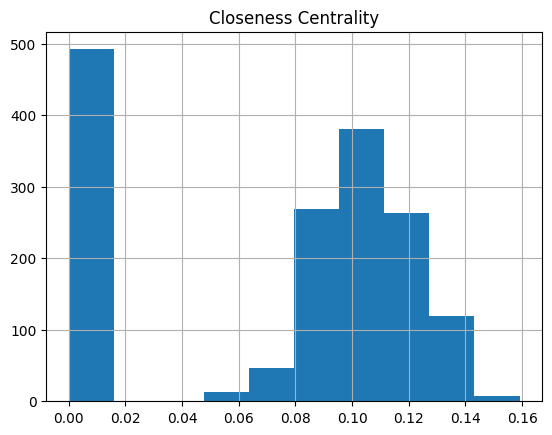

In [99]:
#Closeness Centrality
closeness = nx.closeness_centrality(G1)
print_centrality(closeness, 'Closeness Centrality')

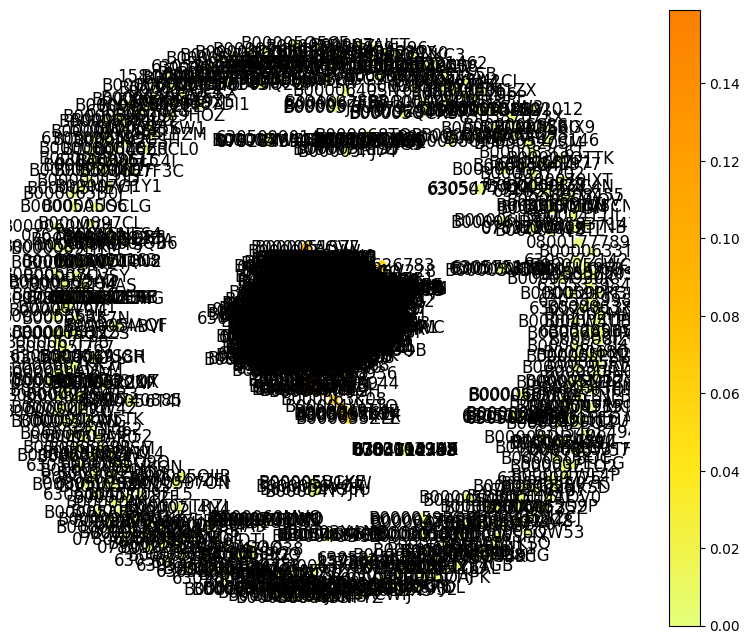

<Figure size 50000x50000 with 0 Axes>

In [100]:
plot_centrality(closeness, G1)

[('B00005U128', 0.47066632050837287), ('6305972052', 0.2621903729178907), ('6305807957', 0.2386113586516338), ('6305840024', 0.18524099631110932), ('157362408X', 0.18478715426137057), ('B00005R24H', 0.15985539515410138), ('B000059PPN', 0.1591697046254798), ('6305807930', 0.15342756908589134), ('B00005LQ04', 0.14410625380302683), ('B00000IBRI', 0.12399754375586657), ('B00004ZEQX', 0.11705023195346408), ('B00005LQ06', 0.11341629966963411), ('B00000IBRJ', 0.10938376686006365), ('B000063K1F', 0.10815762257205606), ('B00005KHJS', 0.10646763352800949), ('B0000640SP', 0.1061825819351833), ('B00000IBRK', 0.10576810309253334), ('B00004ZEQY', 0.10451167867060887), ('6305972079', 0.10451167867060887), ('B00006ADDD', 0.09989963871901965), ('630597229X', 0.09926772245159772), ('B00005RYLB', 0.09852987811847044), ('B00005UQ9H', 0.09539496055853153), ('B00005B6LA', 0.09437631029367755), ('B000067J0H', 0.09200111946891637), ('B0000640SQ', 0.09076866469224296), ('B00000JT2R', 0.08806680504435059), ('B0

ASIN  Eigenvector Centrality
7     B00005U128            4.706663e-01
8     6305972052            2.621904e-01
14    6305807957            2.386114e-01
91    6305840024            1.852410e-01
141   157362408X            1.847872e-01
...          ...                     ...
1041  B00006HAWZ            3.855518e-52
1039  B00005V9I1            3.855518e-52
1038  B00005V9IC            3.855518e-52
1023  0767844335            3.855518e-52
1589  B000059TOC            3.855518e-52

[1590 rows x 2 columns]

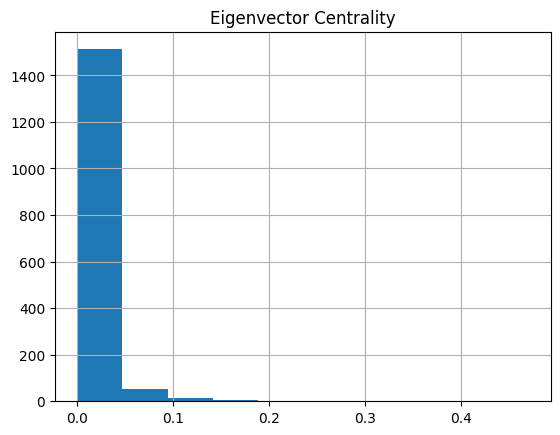

In [102]:
#Eigenvector centrality
eigenvector = nx.eigenvector_centrality(G1)
print_centrality(eigenvector, 'Eigenvector Centrality')

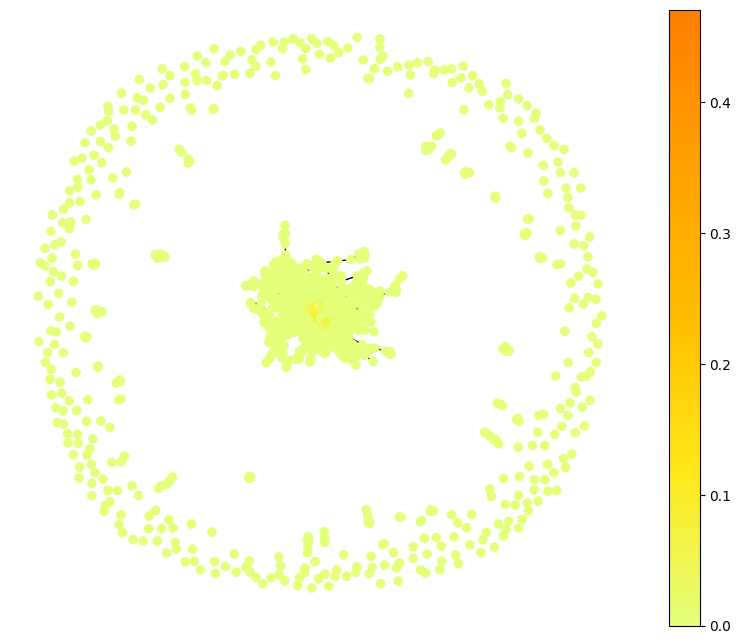

<Figure size 50000x50000 with 0 Axes>

In [103]:
plot_centrality(eigenvector, G1)

#### Centrality merics for DVD category: Comedy

In [ ]:
df_comedy = amazon_dvd_df[amazon_dvd_df['categories'].str.contains('comedy')]
len(df_comedy)

3564

In [ ]:
dvd_comedy = {}
for key, value in amazon_dvd.items():
    if('comedy' in (value['categories'])):
        dvd_comedy[key] = amazon_dvd[key]

for key, value in dvd_comedy.items():
    dvd_comedy[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in dvd_comedy.keys()])

In [ ]:
# Transformation of comedy category of DVD data into graph
G2 = nx.Graph()
for key, value in dvd_comedy.items():
    G2.add_node(key)
    for i in value['connections'].split():
        G2.add_node(i.strip())
        similarity = 0
        try:
            set_1 = set(dvd_comedy[key]['categories'].split())
            set_2 = set(dvd_comedy[i]['categories'].split())
        except KeyError:
            continue
        union = set_1 & set_2
        intersection = set_1 | set_2
        if(len(union)) > 0:
            similarity = round(len(intersection)/len(union),2)
        G2.add_edge(key, i.strip(), weight=similarity)

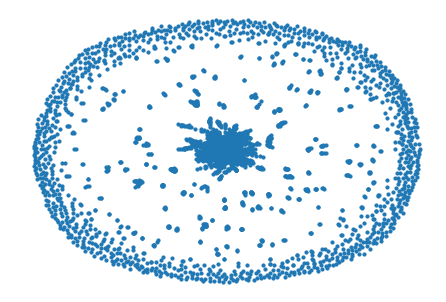

In [ ]:
pos=nx.spring_layout(G2)
nx.draw(G2,pos,node_size=10, width=0.1)

[('B00003CXIY', 26), ('B000069CF0', 26), ('6304765266', 25), ('6305368171', 25), ('B00005JM1F', 20), ('630529142X', 19), ('B00004RF97', 18), ('0780618556', 17), ('B000023VTP', 17), ('B00008NRI8', 17), ('6305505780', 16), ('B000067J1Y', 16), ('0790731479', 16), ('B00003CXD3', 16), ('B000031WD9', 16), ('B00001MXXH', 15), ('B000067J1Z', 15), ('630580379X', 15), ('B00000K31Q', 15), ('B00004Y62W', 15), ('0783240201', 15), ('B000094J7Z', 14), ('6305428255', 14), ('B00004RF8A', 14), ('B00005JL72', 14), ('B00004YS70', 14), ('6305168857', 14), ('6305433852', 13), ('B000022TSL', 13), ('6305310343', 13), ('6305609675', 13), ('B00005NVDF', 13), ('B00008ZZ7B', 13), ('B00003CY6D', 12), ('B00005S8KU', 12), ('0783227884', 12), ('B000035Z28', 12), ('B000035Z1Z', 12), ('B00003CXPJ', 12), ('B00007G1Z9', 12), ('6305803781', 12), ('B00005PJ6O', 12), ('B000065V3H', 11), ('0780625145', 11), ('B00005T7I0', 11), ('157362408X', 11), ('B00003IPFP', 11), ('6305428050', 11), ('B00003CXMP', 11), ('B00005JL1T', 11),

ASIN  Degree Centrality
294   B00003CXIY                 26
353   B000069CF0                 26
711   6304765266                 25
385   6305368171                 25
354   B00005JM1F                 20
...          ...                ...
2287  B00006IUH7                  0
2281  B00005OSKI                  0
2280  B00005OSK0                  0
2279  B00008YRU0                  0
3563  B00006JBIX                  0

[3564 rows x 2 columns]

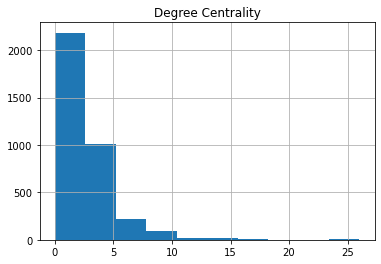

In [ ]:
#Degree Centrality
degree = dict(nx.degree(G2))
print_centrality(degree, 'Degree Centrality')

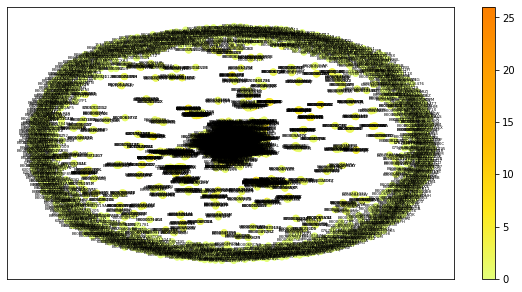

In [ ]:
plot_centrality(degree, G2)

In [ ]:
#Betweenness centrality
betweenness = nx.betweenness_centrality(G2)
print_centrality(betweenness, 'Betweenness Centrality')

[('B00003CXD3', 0.03613845841637841), ('6304765266', 0.034121422516765004), ('B00001MXXH', 0.02288764665492543), ('6305840083', 0.02015857427299246), ('6305310343', 0.019890183260097248), ('B00004Y62W', 0.019332648982237674), ('B00003CXD0', 0.017151564383697224), ('0780626494', 0.01643751279271618), ('0767827813', 0.015708402904582773), ('B00004RF97', 0.015279557823734028), ('B00008MTY0', 0.014535417468401377), ('B000055ZF0', 0.014498440750540412), ('6305641587', 0.014350645262371097), ('B00003CWQ9', 0.014012998109661869), ('6305803781', 0.013827307206707287), ('B000068DBC', 0.013415545889085325), ('6305161879', 0.013333973044376286), ('B00003CXPJ', 0.012715582503011079), ('B00004RF8A', 0.01262396288622243), ('6305168857', 0.01260361748737388), ('B000067J1Y', 0.012601261084749009), ('B00000K31Q', 0.012601205068913865), ('B00003CXDV', 0.012573788170912209), ('6305368171', 0.012501705087277153), ('6305505780', 0.012366026757282298), ('0790731479', 0.012347336720383895), ('B00005PJ6O', 0.

ASIN  Betweenness Centrality
51    B00003CXD3                0.036138
831   6304765266                0.034121
784   B00001MXXH                0.022888
190   6305840083                0.020159
103   6305310343                0.019890
...          ...                     ...
1915  B0000633TJ                0.000000
1914  1573629065                0.000000
1913  B00004YS8H                0.000000
1910  B00004YS8N                0.000000
3563  B00006JBIX                0.000000

[3564 rows x 2 columns]

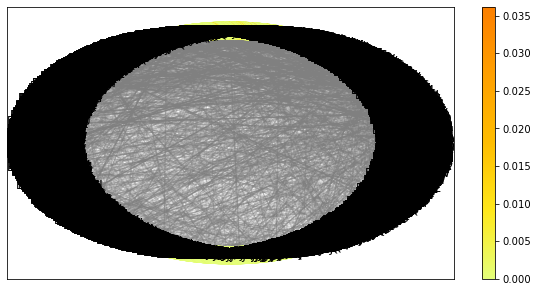

In [ ]:
plot_centrality(betweenness, G2)

In [ ]:
#Closeness Centrality
closeness = nx.closeness_centrality(G2)
print_centrality(closeness, 'Closeness Centrality')

[('6304765266', 0.10651479864798342), ('B00003CXD3', 0.1052886786175018), ('B00001MXXH', 0.1043024280643526), ('B00005PJ6O', 0.10346807606222179), ('6305368171', 0.10273755691158992), ('B00003CXDC', 0.10246626465120083), ('6304907613', 0.10147562479959242), ('6305133468', 0.10125096144113678), ('6305161879', 0.0996436782620852), ('0780626494', 0.09959717736221955), ('B000035Z1Z', 0.09886665452023292), ('0783229364', 0.09819945623819454), ('6305265666', 0.09797405580306479), ('6305696071', 0.09791412366921981), ('0767827813', 0.09767512657101883), ('B00008NRI8', 0.0976602279855138), ('B00003CXD0', 0.09762300139864731), ('B000059HAK', 0.09753377327641533), ('B00005AAA9', 0.09724490502324247), ('B000068MC0', 0.09717848594870279), ('6305803781', 0.09711215754179106), ('B00005S6K8', 0.09693572364466743), ('B00000K3TP', 0.09685507218410534), ('B00000JRTX', 0.09680381836604603), ('B000035Z3C', 0.09673800025278059), ('B00005QCVV', 0.09635221289285605), ('B00005UM23', 0.09633046786624967), ('07

ASIN  Closeness Centrality
831   6304765266              0.106515
51    B00003CXD3              0.105289
784   B00001MXXH              0.104302
953   B00005PJ6O              0.103468
440   6305368171              0.102738
...          ...                   ...
2535  B00006RCNK              0.000000
2536  B00006RCNA              0.000000
2537  B00006RCNV              0.000000
2546  630594427X              0.000000
3563  B00006JBIX              0.000000

[3564 rows x 2 columns]

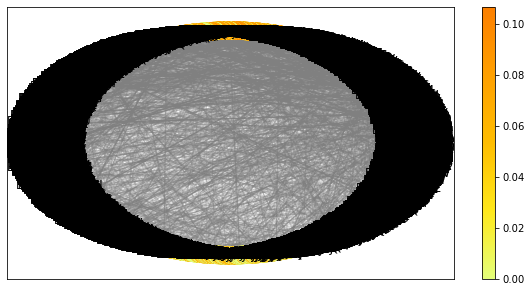

In [ ]:
plot_centrality(closeness, G2)

### Centrality merics for DVD category: Documentary

In [ ]:
df_documentary = amazon_dvd_df[amazon_dvd_df['categories'].str.contains('documentary')]
len(df_documentary)

1475

In [ ]:
dvd_documentary = {}
for key, value in amazon_dvd.items():
    if('documentary' in (value['categories'])):
        dvd_documentary[key] = amazon_dvd[key]

for key, value in dvd_documentary.items():
    dvd_documentary[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in dvd_documentary.keys()])

In [ ]:
# Transformation of documentary category of DVD data into graph
G3 = nx.Graph()
for key, value in dvd_documentary.items():
    G3.add_node(key)
    for i in value['connections'].split():
        G3.add_node(i.strip())
        similarity = 0
        try:
            set_1 = set(dvd_documentary[key]['categories'].split())
            set_2 = set(dvd_documentary[i]['categories'].split())
        except KeyError:
            continue
        union = set_1 & set_2
        intersection = set_1 | set_2
        if(len(union)) > 0:
            similarity = round(len(intersection)/len(union),2)
        G3.add_edge(key, i.strip(), weight=similarity)

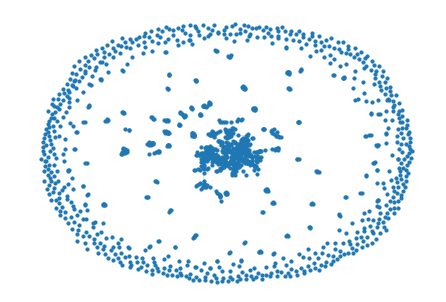

In [ ]:
pos=nx.spring_layout(G3)
nx.draw(G3,pos,node_size=10, width=0.1)

In [ ]:
#Degree Centrality
degree = dict(nx.degree(G3))
print_centrality(degree, 'Degree Centrality')

[('B00004VWUF', 21), ('B00005BIG3', 16), ('B000093NQZ', 15), ('B00001U0E2', 15), ('6305461821', 15), ('B00004TJR8', 14), ('B00004TJR2', 14), ('B000056OZ5', 13), ('0767026977', 13), ('6305462178', 12), ('B00008YLV1', 12), ('B00005A07W', 12), ('B00005BIFZ', 12), ('B000063K1J', 11), ('B000060MW1', 11), ('B00004WMFS', 11), ('B00005B1YQ', 10), ('B00006FMC8', 10), ('B00006BS70', 9), ('B00006B1HI', 9), ('B000059H6U', 9), ('B00005MKL5', 9), ('B00002SSKM', 9), ('B00004Z4VD', 9), ('B00006FMCG', 9), ('B00005AUEC', 9), ('B00004XMTF', 9), ('B0000648XV', 9), ('B00004YKPT', 9), ('B000069HXC', 9), ('B00005B1YF', 9), ('B00005RY9P', 9), ('B00004Y7H8', 8), ('B00008AOW1', 8), ('B00003RQLS', 8), ('B00004TX2W', 8), ('B00005UM2Z', 8), ('B00005Q2Z4', 8), ('6305462534', 8), ('B00005MKOP', 8), ('B00004Y7H9', 8), ('B000053VC9', 8), ('B00005B1XD', 8), ('B0000646UC', 8), ('6305320616', 8), ('B00008OM6K', 8), ('B00000JNTN', 8), ('B00006FDD9', 7), ('B000067J0I', 7), ('6305222444', 7), ('B00005B1YE', 7), ('B000087F6O

ASIN  Degree Centrality
28    B00004VWUF                 21
35    B00005BIG3                 16
411   B000093NQZ                 15
17    B00001U0E2                 15
70    6305461821                 15
...          ...                ...
844   0972597506                  0
845   B00000JKNU                  0
846   6305186553                  0
847   B0000541UN                  0
1474  B000007SFG                  0

[1475 rows x 2 columns]

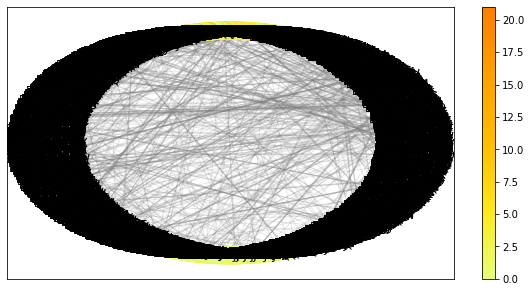

In [ ]:
plot_centrality(degree, G3)

In [ ]:
#Betweenness centrality
betweenness = nx.betweenness_centrality(G3)
print_centrality(betweenness, 'Betweenness Centrality')

[('0767026977', 0.040256253125825904), ('B000093NQZ', 0.03283605214439227), ('B0000646UC', 0.02988313698164671), ('B00006RCKI', 0.02856850173224281), ('B00004TX2W', 0.027829296708525995), ('B00005NOOH', 0.027592858612524633), ('B00003XALS', 0.02701596948053363), ('B00008AOW1', 0.023998893080577864), ('0792299922', 0.020482016659754368), ('B00005BIG3', 0.020470797966888367), ('B00005NTOG', 0.02046353503304374), ('1558908676', 0.01987266683847035), ('B00003RQLS', 0.019550539703653735), ('B00005KHJX', 0.019155365723075593), ('B00005B1YQ', 0.01769302846700397), ('B00006LPDB', 0.017560873015202715), ('B00005Y726', 0.017559873834610648), ('B00001U0E2', 0.01699504015747719), ('B00004YZFR', 0.016683385516409806), ('B00005RRID', 0.0160597426954928), ('B00005MKIX', 0.015390238416406543), ('B00006HAZF', 0.014380962264850503), ('B000055XOB', 0.0140926546677831), ('B00004T39I', 0.013204580399085177), ('B00005B1YF', 0.012962672540322635), ('B00004VWUF', 0.012738612046486585), ('B000053V7G', 0.012510

ASIN  Betweenness Centrality
169   0767026977                0.040256
411   B000093NQZ                0.032836
171   B0000646UC                0.029883
465   B00006RCKI                0.028569
653   B00004TX2W                0.027829
...          ...                     ...
685   630520294X                0.000000
688   B0000665TJ                0.000000
689   B00006674W                0.000000
690   B00005UQ9C                0.000000
1474  B000007SFG                0.000000

[1475 rows x 2 columns]

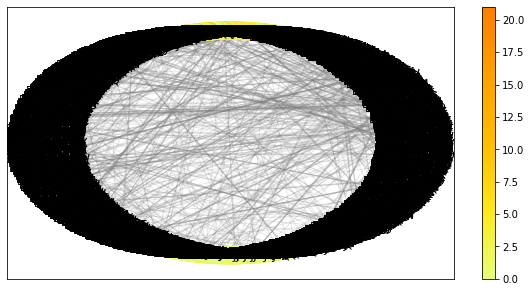

In [ ]:
plot_centrality(degree, G3)

In [ ]:
#Closeness Centrality
closeness = nx.closeness_centrality(G3)
print_centrality(closeness, 'Closeness Centrality')

[('0767026977', 0.048941944784595424), ('B00005NOOH', 0.0475767411902584), ('B00006RCKI', 0.04742455181145098), ('B00003RQLS', 0.04674590797034606), ('B0000646UC', 0.04611949714327274), ('B00005U8F3', 0.045954549013289644), ('B00005AUDY', 0.04591076192513978), ('B00005QW4L', 0.045552677514000654), ('B000065U2E', 0.04532769956767093), ('B00000JYWU', 0.045285098346272736), ('B00005NTOG', 0.04501013044412349), ('1586640054', 0.044999621424640854), ('B00005RRID', 0.044894800503549215), ('B000050HEM', 0.04447009196163747), ('B0000524FH', 0.044053343671254123), ('B00008V2WT', 0.04398297091778566), ('0767025784', 0.043793087607756596), ('B00006G8K7', 0.04377319522183438), ('B00004ZERN', 0.04374339050425256), ('0792299922', 0.043418197468289434), ('B00005QBYA', 0.04331087158690714), ('B000059TO6', 0.04323314907172202), ('B00006LPDB', 0.043213762009358024), ('B00005Q66E', 0.043136387323575824), ('B00005NKTI', 0.04312673496570526), ('B00005K2XN', 0.04311708692656304), ('B00003XALS', 0.0430785378

ASIN  Closeness Centrality
169   0767026977              0.048942
520   B00005NOOH              0.047577
465   B00006RCKI              0.047425
170   B00003RQLS              0.046746
171   B0000646UC              0.046119
...          ...                   ...
844   0972597506              0.000000
845   B00000JKNU              0.000000
846   6305186553              0.000000
847   B0000541UN              0.000000
1474  B000007SFG              0.000000

[1475 rows x 2 columns]

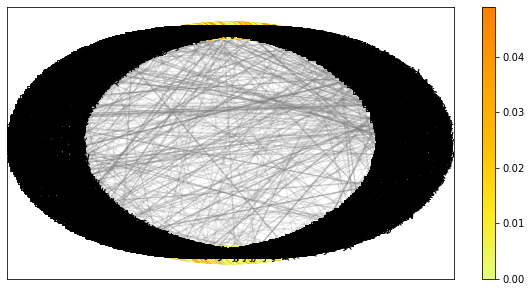

In [ ]:
plot_centrality(closeness, G3)

### Centrality merics for DVD category: Kids

In [ ]:
df_kids = amazon_dvd_df[amazon_dvd_df['categories'].str.contains('kids')]
len(df_kids)

1861

In [ ]:
dvd_kids = {}
for key, value in amazon_dvd.items():
    if('kids' in (value['categories'])):
        dvd_kids[key] = amazon_dvd[key]

for key, value in dvd_kids.items():
    dvd_kids[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in dvd_kids.keys()])

In [ ]:
# Transformation of kids category of DVD data into graph
G4 = nx.Graph()
for key, value in dvd_kids.items():
    G4.add_node(key)
    for i in value['connections'].split():
        G4.add_node(i.strip())
        similarity = 0
        try:
            set_1 = set(dvd_kids[key]['categories'].split())
            set_2 = set(dvd_kids[i]['categories'].split())
        except KeyError:
            continue
        union = set_1 & set_2
        intersection = set_1 | set_2
        if(len(union)) > 0:
            similarity = round(len(intersection)/len(union),2)
        G4.add_edge(key, i.strip(), weight=similarity)

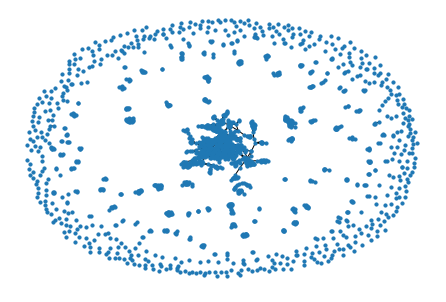

In [ ]:
pos=nx.spring_layout(G4)
nx.draw(G4,pos,node_size=10, width=1)

In [ ]:
#Degree Centrality
degree = dict(nx.degree(G4))
print_centrality(degree, 'Degree Centrality')

[('B00001QEE7', 24), ('B00005QFDX', 23), ('B00004VVP9', 22), ('B00004VVPA', 20), ('B00005LKHZ', 19), ('B00007G1Z9', 18), ('B0000648Y2', 18), ('B00004YKPP', 17), ('B00004U3V1', 17), ('B0000648Y4', 17), ('B00005YUPQ', 17), ('6304711913', 16), ('B0000648WV', 16), ('B0000687DQ', 15), ('B00004YKPQ', 15), ('B00005NX1L', 15), ('B00005KARK', 14), ('B00007J88T', 14), ('B000059XUT', 14), ('B00004U3V3', 14), ('B00004R9A0', 14), ('B00003CXCZ', 14), ('B0000687DT', 13), ('B00003CX8Y', 13), ('B00001QEE6', 13), ('6305940959', 13), ('0738920762', 13), ('B00005JKDR', 13), ('B000065U1M', 13), ('B00003CXCQ', 12), ('B00001QEE8', 12), ('B000063N5K', 12), ('B00005NGA3', 12), ('B00005JKHN', 12), ('6304698690', 12), ('B00008AOWX', 12), ('B0000640SW', 11), ('B00000IBWR', 11), ('B00005UF7Q', 11), ('B00007M5J1', 11), ('B000083C50', 11), ('B00004R99J', 11), ('B0000640SU', 11), ('B00004W5UM', 11), ('B00003CXDD', 11), ('B00005A08O', 11), ('B0000648WU', 11), ('B00008977W', 11), ('B00008W2TQ', 11), ('B000068GFY', 10),

ASIN  Degree Centrality
58    B00001QEE7                 24
372   B00005QFDX                 23
149   B00004VVP9                 22
15    B00004VVPA                 20
222   B00005LKHZ                 19
...          ...                ...
132   B00006FDAH                  0
788   B00006CJMJ                  0
1409  B00005Y6ZK                  0
1407  B00007L4I6                  0
0     B000056PNB                  0

[1861 rows x 2 columns]

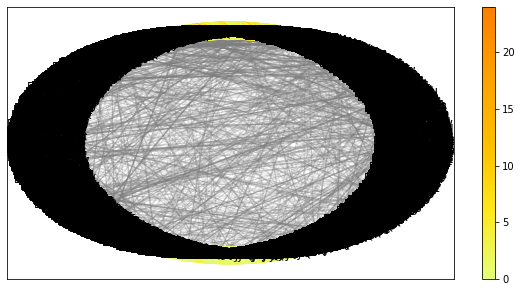

In [ ]:
plot_centrality(degree, G4)

In [ ]:
#Betweenness centrality
betweenness = nx.betweenness_centrality(G4)
print_centrality(betweenness, 'Betweenness Centrality')

[('B00005LKHZ', 0.022785705368969), ('6304711913', 0.02256744489984295), ('B00006CXGO', 0.01996783821660396), ('6304698690', 0.01962391362152067), ('B00006RJAK', 0.01930508181631053), ('B00007G1Z9', 0.016609043841956803), ('B000062XG2', 0.016346648625407433), ('630595027X', 0.015876771873875963), ('B00004VVP9', 0.015360388132218227), ('B00005OSJS', 0.014973063790109833), ('B00005UF84', 0.012446274315222704), ('B00004VVPA', 0.012226805604857631), ('B00005KARK', 0.012150257186392534), ('B00007GZR9', 0.012077810943221589), ('B00000K3CL', 0.011153442595611794), ('B00000JKNR', 0.011060242501329332), ('B000060MWN', 0.010733255803465624), ('B00003CXCZ', 0.010648477521926655), ('B00006K11W', 0.009917389159524195), ('B000069I1L', 0.009913502751902063), ('B00007G1ZF', 0.009801445443438077), ('B00004R9A4', 0.009795877341498855), ('B000065V41', 0.009686352187116788), ('6304604564', 0.009307181793802605), ('B00000JS62', 0.009279414103983396), ('B000053VAI', 0.008958463108180553), ('B00001QEE9', 0.0

ASIN  Betweenness Centrality
222   B00005LKHZ                0.022786
34    6304711913                0.022567
1128  B00006CXGO                0.019968
601   6304698690                0.019624
390   B00006RJAK                0.019305
...          ...                     ...
565   B00005OSLM                0.000000
563   B00005QBZ4                0.000000
1192  0790730987                0.000000
1193  B000068TQ4                0.000000
0     B000056PNB                0.000000

[1861 rows x 2 columns]

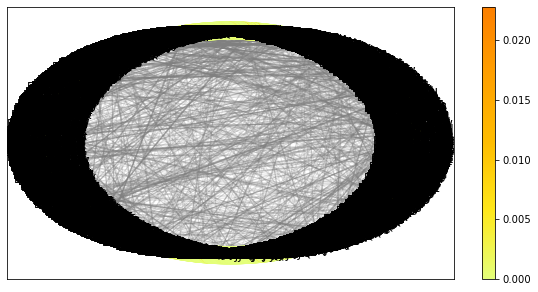

In [ ]:
plot_centrality(betweenness, G4)

In [ ]:
#Closeness Centrality
closeness = nx.closeness_centrality(G4)
print_centrality(closeness, 'Closeness Centrality')

[('B00005LKHZ', 0.06437132728845743), ('630595027X', 0.06433771301833291), ('B00007G1ZF', 0.06289265973971797), ('6304711913', 0.06287661159995281), ('6305161887', 0.06279649359332697), ('6304698690', 0.06273254604384293), ('B000062XG2', 0.062320040682907196), ('B00005QJEF', 0.06199080273212958), ('B00006RCOD', 0.06160336021505376), ('B00007G1Z9', 0.061403797871969854), ('B00005UW9S', 0.06061831263473924), ('B00005LK94', 0.060499248922223185), ('6304604564', 0.060380652011814515), ('B00005TSMN', 0.06017422243228694), ('B00000JS62', 0.06007153604588372), ('0792839749', 0.05999840293650232), ('B000056H2C', 0.059969199527917995), ('B000056H26', 0.05978006813687895), ('B00004TJTS', 0.05950578141999881), ('B00005KARK', 0.05937673273740121), ('B00007JMDX', 0.059262491789373505), ('B00005BCK4', 0.0592055360067792), ('B00005N89B', 0.0592055360067792), ('B00005UF84', 0.059106126375681224), ('B00000JMQE', 0.058964690323095245), ('6304698569', 0.058809890420099056), ('B00000K3D4', 0.0586838392141

ASIN  Closeness Centrality
222   B00005LKHZ              0.064371
539   630595027X              0.064338
789   B00007G1ZF              0.062893
34    6304711913              0.062877
758   6305161887              0.062796
...          ...                   ...
194   B000059PPF              0.000000
1537  0783226039              0.000000
1536  B00005NI9E              0.000000
1142  6305844674              0.000000
0     B000056PNB              0.000000

[1861 rows x 2 columns]

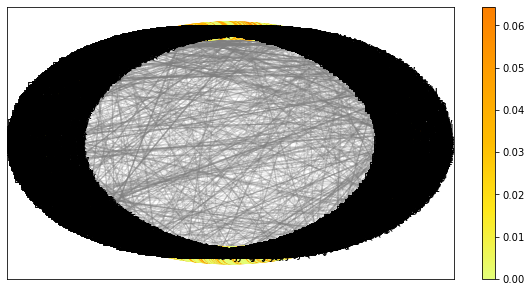

In [ ]:
plot_centrality(closeness, G4)

### Centrality merics for DVD category: Drama

In [ ]:
df_drama = amazon_dvd_df[amazon_dvd_df['categories'].str.contains('drama')]
len(df_drama)

4724

In [ ]:
dvd_drama = {}
for key, value in amazon_dvd.items():
    if('drama' in (value['categories'])):
        dvd_drama[key] = amazon_dvd[key]

for key, value in dvd_drama.items():
    dvd_drama[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in dvd_drama.keys()])

In [ ]:
# Transformation of drama category of DVD data into graph
G5 = nx.Graph()
for key, value in dvd_drama.items():
    G5.add_node(key)
    for i in value['connections'].split():
        G5.add_node(i.strip())
        similarity = 0
        try:
            set_1 = set(dvd_drama[key]['categories'].split())
            set_2 = set(dvd_drama[i]['categories'].split())
        except KeyError:
            continue
        union = set_1 & set_2
        intersection = set_1 | set_2
        if(len(union)) > 0:
            similarity = round(len(intersection)/len(union),2)
        G5.add_edge(key, i.strip(), weight=similarity)

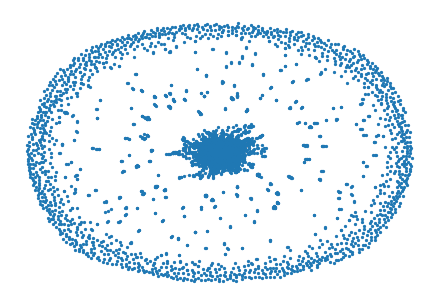

In [ ]:
pos=nx.spring_layout(G5)
nx.draw(G5,pos,node_size=5, width=0.1)

In [ ]:
#Degree Centrality
degree = dict(nx.degree(G5))
print_centrality(degree, 'Degree Centrality')

[('B0000541AK', 27), ('630469623X', 22), ('B00007ELED', 22), ('6305078629', 21), ('B00002RAPT', 21), ('B000022TSH', 20), ('B00002ND77', 20), ('6305976333', 19), ('B00005JM6H', 19), ('B00005JLG1', 18), ('B00003CXA2', 18), ('0792845803', 18), ('6304765266', 17), ('B00005AUJQ', 17), ('0767830555', 17), ('0790729377', 16), ('B000068TPN', 16), ('B000065RSW', 16), ('B00006RCO1', 16), ('6305368171', 16), ('6305216088', 16), ('6305161941', 16), ('B00006FDCP', 16), ('B00005RYOQ', 15), ('B00005V4XV', 15), ('B000059H6T', 15), ('B00004W5P5', 15), ('B00006JU7T', 14), ('1573623768', 14), ('0792833287', 14), ('0800141660', 14), ('B00005QW5T', 14), ('B00005RRJF', 14), ('6305144168', 14), ('B000065V3B', 14), ('6305428476', 14), ('6305181810', 14), ('B00005PJ8V', 13), ('B00000K0DS', 13), ('B00008ZZ9M', 13), ('6305262268', 13), ('B00003CWL6', 13), ('0783240171', 13), ('B00005B6JZ', 13), ('B00003JRCQ', 13), ('B000065U1N', 13), ('0800141741', 13), ('B00005U5AH', 13), ('6305280770', 12), ('6305310335', 12),

ASIN  Degree Centrality
53    B0000541AK                 27
79    630469623X                 22
470   B00007ELED                 22
9     6305078629                 21
1665  B00002RAPT                 21
...          ...                ...
3039  B0000897AA                  0
3034  B00005NKTG                  0
3025  B00007JZV2                  0
3024  B00007JZVI                  0
4723  B000059TOC                  0

[4724 rows x 2 columns]

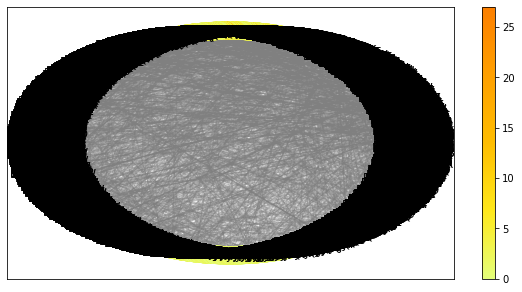

In [ ]:
plot_centrality(degree, G5)

In [ ]:
#Betweenness centrality
betweenness = nx.betweenness_centrality(G5)
print_centrality(betweenness, 'Betweenness Centrality')

[('B000022TSH', 0.040342308117526614), ('B00003CX9E', 0.024109639474774226), ('0792845803', 0.02181282782725172), ('6304698518', 0.020609589599517877), ('B00001U0E1', 0.018940019522603716), ('0790729377', 0.016753278371284132), ('0783240171', 0.016411924258487986), ('B00003CXA4', 0.016224828675002696), ('B00006FDCP', 0.01614093169070095), ('1573623768', 0.015547551105953239), ('B000053VBK', 0.015511513714371008), ('0767830555', 0.01510612797542028), ('B00006DEFA', 0.014600100385621477), ('6305262268', 0.014092566905345444), ('B00007ELED', 0.012759210729593547), ('0800141660', 0.012458868607488335), ('6305428476', 0.012415167396280078), ('B00005V4XV', 0.011615642477336053), ('B00004XMV6', 0.011414946637338863), ('6305216088', 0.011221441475713193), ('B00007AJF9', 0.011052004901670688), ('B000063US3', 0.010632038971864474), ('0792833287', 0.010216515903090362), ('B0000844I6', 0.010135241175459924), ('B00002RAPT', 0.01006298981163305), ('B00003CXBU', 0.010055606007813241), ('B00003CWL6', 

ASIN  Betweenness Centrality
94    B000022TSH                0.040342
2295  B00003CX9E                0.024110
469   0792845803                0.021813
90    6304698518                0.020610
756   B00001U0E1                0.018940
...          ...                     ...
2445  B00004W5SZ                0.000000
2446  B00004W5SS                0.000000
2449  B000065V3T                0.000000
2452  B000065V3X                0.000000
4723  B000059TOC                0.000000

[4724 rows x 2 columns]

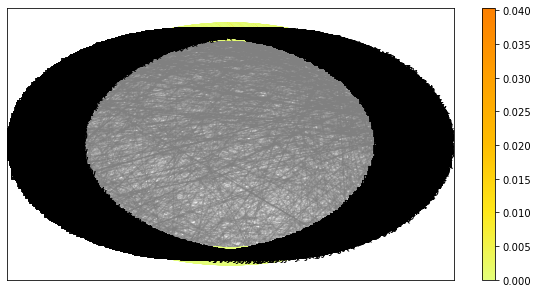

In [ ]:
plot_centrality(betweenness, G5)

In [ ]:
#Closeness Centrality
closeness = nx.closeness_centrality(G5)
print_centrality(closeness, 'Closeness Centrality')

[('B000022TSH', 0.09688066909874726), ('B00006FDCP', 0.09384674677940825), ('6304698518', 0.09281773706510285), ('0767830555', 0.09176487605570322), ('B00006DEFA', 0.09170338518499356), ('0792833287', 0.09115871339954842), ('B00000K0DS', 0.09056050633577065), ('0783240171', 0.09045575444190938), ('6304712960', 0.09016274414696744), ('B00006JU7T', 0.08994546072367537), ('B00003CXA4', 0.08960193266547713), ('B00001U0E1', 0.08930470508961144), ('6305262268', 0.08928042959078313), ('B00005JKQZ', 0.0889515882294911), ('6305216088', 0.08888899712545953), ('0767817486', 0.08824892374081708), ('B00003CX9E', 0.08773502627913586), ('B00000ING1', 0.08766009511545132), ('B00003CXBU', 0.08753393859031314), ('6305558159', 0.08750129059531463), ('B00003CX9I', 0.08745935036975368), ('B000022TSF', 0.08741745032965319), ('B00003CXCW', 0.08732912639685536), ('079073219X', 0.08712989292725301), ('0790734850', 0.08686718973249748), ('B00002VWE0', 0.08663347868183503), ('B00004WLTJ', 0.0866197701299048), ('

ASIN  Closeness Centrality
94    B000022TSH              0.096881
757   B00006FDCP              0.093847
90    6304698518              0.092818
902   0767830555              0.091765
755   B00006DEFA              0.091703
...          ...                   ...
3039  B0000897AA              0.000000
3034  B00005NKTG              0.000000
3025  B00007JZV2              0.000000
3024  B00007JZVI              0.000000
4723  B000059TOC              0.000000

[4724 rows x 2 columns]

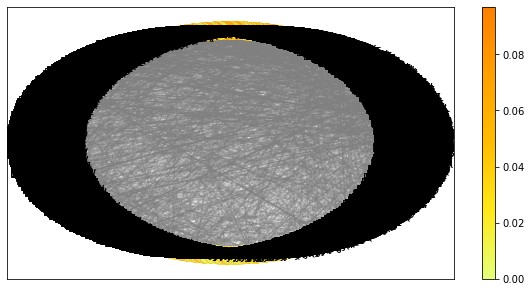

In [ ]:
plot_centrality(closeness, G5)

### Centrality merics for DVD category: Anime

In [ ]:
df_anime = amazon_dvd_df[amazon_dvd_df['categories'].str.contains('anime')]
len(df_anime)

1418

In [ ]:
dvd_anime = {}
for key, value in amazon_dvd.items():
    if('anime' in (value['categories'])):
        dvd_anime[key] = amazon_dvd[key]

for key, value in dvd_anime.items():
    dvd_anime[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in dvd_anime.keys()])

In [ ]:
# Transformation of anime category of DVD data into graph
G6 = nx.Graph()
for key, value in dvd_anime.items():
    G6.add_node(key)
    for i in value['connections'].split():
        G6.add_node(i.strip())
        similarity = 0
        try:
            set_1 = set(dvd_anime[key]['categories'].split())
            set_2 = set(dvd_anime[i]['categories'].split())
        except KeyError:
            continue
        union = set_1 & set_2
        intersection = set_1 | set_2
        if(len(union)) > 0:
            similarity = round(len(intersection)/len(union),2)
        G6.add_edge(key, i.strip(), weight=similarity)

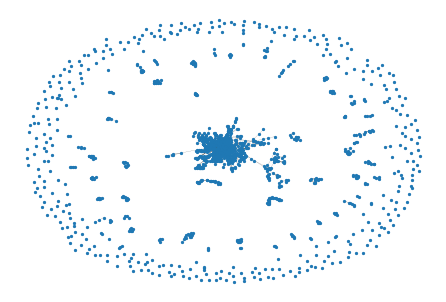

In [ ]:
pos=nx.spring_layout(G6)
nx.draw(G6,pos,node_size=5, width=0.1)

In [ ]:
#Degree Centrality
degree = dict(nx.degree(G6))
print_centrality(degree, 'Degree Centrality')

[('B00008L3MH', 44), ('B00008RH3Y', 43), ('6305014140', 40), ('B00005OW09', 40), ('B0000639E0', 33), ('6304493681', 32), ('B00000IBWR', 30), ('B00005QCW4', 24), ('B00005NX1L', 19), ('B00005NX1N', 19), ('B00008DDWN', 16), ('B00005B1ZN', 15), ('B00004VVOJ', 15), ('B00008G8PM', 14), ('6305596344', 14), ('B00005094M', 14), ('B00005V1XW', 14), ('B000065U3N', 13), ('B000066IXV', 13), ('B00006CY42', 13), ('1573306886', 13), ('B0000844M4', 13), ('B00006G8EP', 13), ('B00000I86K', 12), ('B000051XK1', 12), ('B00004YZGB', 12), ('B00004YA10', 12), ('B00005JMBJ', 12), ('B00006JMPO', 11), ('B00007K019', 11), ('B000063K2F', 11), ('B00005LP4A', 11), ('B00005BJPK', 11), ('B000087F31', 11), ('B00004U3V1', 11), ('B00005NG68', 11), ('B00008G8PK', 11), ('B00005Q65W', 11), ('B00004Y7JH', 11), ('B00009B8CV', 11), ('B00005BJEB', 11), ('B0000844JY', 10), ('B00007M5JI', 10), ('B000065AYF', 10), ('B00007K000', 10), ('B000068M9S', 10), ('B00005Q65V', 10), ('B00003CXBK', 10), ('B00005AAA6', 10), ('B00005BGRO', 10),

ASIN  Degree Centrality
64    B00008L3MH                 44
7     B00008RH3Y                 43
185   6305014140                 40
76    B00005OW09                 40
62    B0000639E0                 33
...          ...                ...
765   B00005NGTM                  0
775   B00005KJP8                  0
777   B000056VMF                  0
778   B000056VME                  0
1417  B00005IBT5                  0

[1418 rows x 2 columns]

In [ ]:
#Betweenness centrality
betweenness = nx.betweenness_centrality(G6)
print_centrality(betweenness, 'Betweenness Centrality')

[('6305014140', 0.044872417766929254), ('B00008L3MH', 0.036960280174359164), ('B0000639E0', 0.03193084666392202), ('B00008RH3Y', 0.031034249898103987), ('B00005OW09', 0.027037778512275224), ('6304493681', 0.01964769906146164), ('B00000IBWR', 0.017589757253743277), ('B000066IXV', 0.01596283756666058), ('B00003CXBK', 0.012488147020372693), ('B00006CY42', 0.011850349406485682), ('B00005NX1N', 0.01178310849398522), ('B000068M9S', 0.011562703359567604), ('B00005QCW4', 0.011153306386651775), ('B00004Z4SV', 0.009799679296840518), ('B00005KB6L', 0.00966150861332474), ('B00005JMBJ', 0.009441342199956723), ('B000065U3N', 0.009370015522195036), ('B00004WJOC', 0.009357623619296734), ('B00005B8U6', 0.009004980234483146), ('B00005B1ZN', 0.007874598549157615), ('6305731934', 0.007715034149492243), ('B00005V1XW', 0.007633709255220339), ('B00005QCW0', 0.007336895228418348), ('B0000694ZG', 0.007206058071706034), ('B000021Y6P', 0.007083079155851664), ('B000083C55', 0.006910814426624748), ('B00006JU84', 0

ASIN  Betweenness Centrality
185   6305014140                0.044872
64    B00008L3MH                0.036960
62    B0000639E0                0.031931
7     B00008RH3Y                0.031034
76    B00005OW09                0.027038
...          ...                     ...
826   B00005K232                0.000000
827   B0000648WP                0.000000
829   B00006CXG0                0.000000
830   B00006CXG1                0.000000
1417  B00005IBT5                0.000000

[1418 rows x 2 columns]

In [ ]:
#Closeness Centrality
closeness = nx.closeness_centrality(G6)
print_centrality(closeness, 'Closeness Centrality')

[('B00008L3MH', 0.13466920250314016), ('B0000639E0', 0.1327906434446831), ('B00005OW09', 0.13090749293601334), ('B00005QCW4', 0.1261896172585348), ('6305014140', 0.12582475673775426), ('B00005NX1N', 0.12438617234058925), ('B000063K2F', 0.12184869442484121), ('B00005B1ZN', 0.12097765530663347), ('B00006CY42', 0.1200243246895599), ('B00000JL4L', 0.11988261946560529), ('6305033951', 0.11917908296639398), ('B000063IMS', 0.11899286564925901), ('B00005JMBJ', 0.11894640221089538), ('B000066IXV', 0.11876091074545929), ('B00008DDWN', 0.11857599691012186), ('B000068M9S', 0.11752381792519408), ('B00008G8QD', 0.11698223351079226), ('B00008G8PB', 0.11698223351079226), ('B0000541S4', 0.1168476164411596), ('B00005B1ZP', 0.11657930962958402), ('B00005094J', 0.11604637564270592), ('6304493681', 0.11490823691516525), ('B00008RH3Y', 0.11469191869808097), ('B00007LLIV', 0.11439043787536728), ('B00006CY45', 0.11409053785097492), ('B00006JU84', 0.11362243045956846), ('B00006FD99', 0.11299025818327264), ('B0

ASIN  Closeness Centrality
64    B00008L3MH              0.134669
62    B0000639E0              0.132791
76    B00005OW09              0.130907
132   B00005QCW4              0.126190
185   6305014140              0.125825
...          ...                   ...
1049  B000056VPS              0.000000
1048  B000083C4E              0.000000
266   B00005IBSX              0.000000
269   B00005UBKD              0.000000
1417  B00005IBT5              0.000000

[1418 rows x 2 columns]

### Centrality merics for DVD category: Mystery

In [ ]:
df_mystery = amazon_dvd_df[amazon_dvd_df['categories'].str.contains('mystery')]
len(df_mystery)

2380

In [ ]:
dvd_mystery = {}
for key, value in amazon_dvd.items():
    if('mystery' in (value['categories'])):
        dvd_mystery[key] = amazon_dvd[key]

for key, value in dvd_mystery.items():
    dvd_mystery[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in dvd_mystery.keys()])

In [ ]:
# Transformation of mystery category of DVD data into graph
G7 = nx.Graph()
for key, value in dvd_mystery.items():
    G7.add_node(key)
    for i in value['connections'].split():
        G7.add_node(i.strip())
        similarity = 0
        try:
            set_1 = set(dvd_mystery[key]['categories'].split())
            set_2 = set(dvd_mystery[i]['categories'].split())
        except KeyError:
            continue
        union = set_1 & set_2
        intersection = set_1 | set_2
        if(len(union)) > 0:
            similarity = round(len(intersection)/len(union),2)
        G7.add_edge(key, i.strip(), weight=similarity)

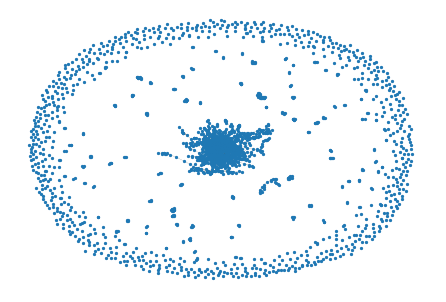

In [ ]:
pos=nx.spring_layout(G7)
nx.draw(G7,pos,node_size=5, width=0.1)

In [ ]:
#Degree Centrality
degree = dict(nx.degree(G7))
print_centrality(degree, 'Degree Centrality')

[('B00008LDNZ', 33), ('B00005ATZT', 21), ('630469623X', 20), ('B0000541AK', 20), ('B00007ELED', 17), ('B000068DBC', 16), ('B00000CQJZ', 16), ('B000055Y14', 16), ('B00000C0QO', 14), ('6305181810', 13), ('B00006FDCF', 13), ('B00005O3V9', 12), ('B00005JJX8', 12), ('B000093NSH', 12), ('6305511055', 12), ('6305807957', 12), ('0790731029', 11), ('0792164962', 11), ('0783226055', 11), ('6305127565', 11), ('B00005OKQZ', 11), ('B000022TSH', 11), ('B000050FEN', 11), ('B00005QAOZ', 11), ('B00005V4XV', 11), ('B00000JQSC', 11), ('B000055Z4M', 10), ('6305999872', 10), ('B000063US3', 10), ('6304884419', 10), ('B000068DBD', 10), ('6305310335', 10), ('B00007AJDT', 10), ('6305127697', 10), ('0792160215', 10), ('B00008QSB4', 10), ('B000035P5E', 10), ('B00007KK43', 9), ('B00008K76V', 9), ('0783225792', 9), ('0790731525', 9), ('B000069HRR', 9), ('0767830555', 9), ('B00003CXI7', 9), ('B000069HRQ', 9), ('B00005NKSA', 9), ('B0000633TA', 9), ('B000056VOO', 9), ('0790739739', 9), ('B00003CXC7', 9), ('B000055Y11

ASIN  Degree Centrality
139   B00008LDNZ                 33
65    B00005ATZT                 21
22    630469623X                 20
23    B0000541AK                 20
107   B00007ELED                 17
...          ...                ...
547   B0000639H2                  0
1564  B00005NFZ8                  0
1565  B00005NFZA                  0
1566  B00005NFZZ                  0
2379  B000059TOC                  0

[2380 rows x 2 columns]

In [ ]:
#Betweenness centrality
betweenness = nx.betweenness_centrality(G7)
print_centrality(betweenness, 'Betweenness Centrality')

[('B00008LDNZ', 0.04134133294023307), ('B000022TSH', 0.02560122084540972), ('B00003CX9I', 0.021469172227048264), ('B00003CXA0', 0.01883127108796684), ('B000063US3', 0.01682980076624725), ('6305511055', 0.015881025665468687), ('0790742780', 0.014991102234637014), ('B00000IRE9', 0.014491273323977554), ('6304884419', 0.014455945843729553), ('B0000844J2', 0.01424538090228392), ('B00005ATZT', 0.014208939478734984), ('0783116934', 0.013991324675560631), ('B00007ELED', 0.01398970041093214), ('630523650X', 0.013950077471269879), ('6305999872', 0.013860583932710382), ('B00005V4XV', 0.013494921751800382), ('6304712960', 0.013116157069488456), ('6304698518', 0.012760957844765879), ('0767804325', 0.012296962301922875), ('6305181810', 0.011264467259281177), ('6305127697', 0.010737744446569577), ('B00005QAOZ', 0.010728856183564811), ('B000050FEN', 0.010688687055558723), ('B00005A3KV', 0.01006670439175689), ('6304765223', 0.010005289790571512), ('6304907648', 0.00991473759029979), ('B00005IAQ8', 0.00

ASIN  Betweenness Centrality
139   B00008LDNZ                0.041341
56    B000022TSH                0.025601
510   B00003CX9I                0.021469
290   B00003CXA0                0.018831
445   B000063US3                0.016830
...          ...                     ...
414   B00005AX6R                0.000000
415   B00005AX6U                0.000000
417   B00005AX6N                0.000000
1288  B000068MAI                0.000000
2379  B000059TOC                0.000000

[2380 rows x 2 columns]

In [ ]:
#Closeness Centrality
closeness = nx.closeness_centrality(G7)
print_centrality(closeness, 'Closeness Centrality')

[('0790742780', 0.062229522233440124), ('6304795254', 0.060738161259639836), ('6304712960', 0.06060260661949399), ('0792164962', 0.06060260661949399), ('0790730979', 0.06051578340084142), ('6305181810', 0.060323730771832076), ('B000022TSH', 0.060170964122204136), ('B00003CXA0', 0.06009487058553363), ('0790741660', 0.06007587726360394), ('6305127697', 0.06002844644308949), ('B000063US3', 0.05983005214417465), ('630542828X', 0.059623612190101274), ('B000050FEN', 0.059595571613746), ('0790729393', 0.059595571613746), ('B000069HZP', 0.05944646619610411), ('6304884419', 0.05940930634850536), ('B00005ATZT', 0.05900359325222501), ('6305310335', 0.05883010698299068), ('0783116934', 0.05876644787820154), ('0767830555', 0.05845919595941654), ('6305128928', 0.05842325977010693), ('B00004REA9', 0.05837840161610653), ('6304907648', 0.05809293265954856), ('6305181969', 0.05800429528899691), ('6305213305', 0.05781903442191419), ('6304712588', 0.05763495320255999), ('B00007G1VS', 0.05754770683077289),

ASIN  Closeness Centrality
156   0790742780              0.062230
154   6304795254              0.060738
2052  6304712960              0.060603
189   0792164962              0.060603
327   0790730979              0.060516
...          ...                   ...
602   1573624101              0.000000
601   B0000399WA              0.000000
1604  B000059H9K              0.000000
1606  B0000694XX              0.000000
2379  B000059TOC              0.000000

[2380 rows x 2 columns]

### Centrality merics for DVD category: Music

In [ ]:
df_music = amazon_dvd_df[amazon_dvd_df['categories'].str.contains('music')]
len(df_music)

3414

In [ ]:
dvd_music = {}
for key, value in amazon_dvd.items():
    if('music' in (value['categories'])):
        dvd_music[key] = amazon_dvd[key]

for key, value in dvd_music.items():
    dvd_music[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in dvd_music.keys()])

In [ ]:
# Transformation of comedy category of DVD data into graph
G8 = nx.Graph()
for key, value in dvd_music.items():
    G8.add_node(key)
    for i in value['connections'].split():
        G8.add_node(i.strip())
        similarity = 0
        try:
            set_1 = set(dvd_music[key]['categories'].split())
            set_2 = set(dvd_music[i]['categories'].split())
        except KeyError:
            continue
        union = set_1 & set_2
        intersection = set_1 | set_2
        if(len(union)) > 0:
            similarity = round(len(intersection)/len(union),2)
        G8.add_edge(key, i.strip(), weight=similarity)

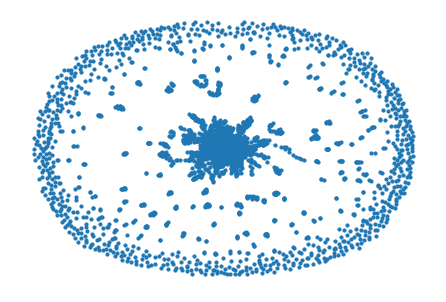

In [ ]:
pos=nx.spring_layout(G8)
nx.draw(G8,pos,node_size=10, width=0.1)

In [ ]:
#Degree Centrality
degree = dict(nx.degree(G8))
print_centrality(degree, 'Degree Centrality')

[('B000059H8T', 30), ('B00000I21X', 25), ('B00005QFDX', 23), ('B00005JLEM', 22), ('B00005RIIP', 21), ('B000050X2Z', 21), ('630522577X', 20), ('B00005NFZS', 20), ('6305079145', 19), ('B000050X31', 18), ('B00005YUPQ', 17), ('B000022TSV', 17), ('6305838550', 17), ('B0000648Y4', 17), ('0783227477', 17), ('6305079188', 17), ('B0000648Y2', 16), ('B00001ODGR', 16), ('B0000648WV', 16), ('B00006J9OV', 15), ('6305838496', 14), ('B00005NGAE', 14), ('B00007J88T', 14), ('B00005A059', 14), ('630583850X', 14), ('B000065U1M', 13), ('B00001AQZD', 13), ('B00005OSLN', 13), ('0738920762', 13), ('B000053VC9', 13), ('B0000687DT', 13), ('B00006LPED', 12), ('B00005Y3ZM', 12), ('B00004YZFR', 12), ('B00000JS6Q', 12), ('B00004UF01', 12), ('B0000687DQ', 12), ('6305280770', 12), ('B00005IB9A', 12), ('6305669449', 12), ('B00005NNSN', 12), ('B000059QY3', 12), ('B000053V7Q', 12), ('B00005NGA3', 12), ('B000059H8C', 12), ('B00005RIXT', 12), ('B00006AUHF', 12), ('B00001NI6Z', 11), ('B00005R5H7', 11), ('6305837708', 11),

ASIN  Degree Centrality
424   B000059H8T                 30
39    B00000I21X                 25
512   B00005QFDX                 23
38    B00005JLEM                 22
36    B00005RIIP                 21
...          ...                ...
2676  B0000682UD                  0
1487  B00000FDRN                  0
1485  B000063S6F                  0
1484  B000056HTH                  0
3413  B00008DDST                  0

[3414 rows x 2 columns]

In [ ]:
#Betweenness centrality
betweenness = nx.betweenness_centrality(G8)
print_centrality(betweenness, 'Betweenness Centrality')

[('B00004Z4TC', 0.06603890745176147), ('B00004UF01', 0.06017214164229156), ('B00000I21X', 0.05723635504951608), ('B00005RIIP', 0.04510237691739761), ('B000059H8T', 0.03851187626188277), ('B00005Y3ZM', 0.03214516168275954), ('B00005JLEM', 0.027731433849862076), ('6305161925', 0.02634171746564855), ('B00005ABSQ', 0.024952552015778888), ('B00005NGA0', 0.0216000114764582), ('B00005R5H4', 0.02078838023151216), ('B00001NI6Z', 0.019950534157208516), ('B00004YZFR', 0.019414785349024286), ('6305382255', 0.01723219625426629), ('B00006AFIV', 0.01715932260341615), ('B00005RT35', 0.017016048575017546), ('B000056MMF', 0.016337912361394407), ('B0000687F4', 0.015920783624922254), ('B00006LPCX', 0.01584692093526969), ('0790729350', 0.015088323442895036), ('B00006G8FQ', 0.014723641079404163), ('B00005R1OA', 0.014370024958904002), ('1573306983', 0.01436810030596368), ('6305943699', 0.014325963690779249), ('1573300861', 0.014324820704034054), ('B00005NGAL', 0.013492497395428035), ('6304498969', 0.01332701

ASIN  Betweenness Centrality
1360  B00004Z4TC                0.066039
1009  B00004UF01                0.060172
39    B00000I21X                0.057236
36    B00005RIIP                0.045102
424   B000059H8T                0.038512
...          ...                     ...
1722  0738919012                0.000000
1719  B00005O6ON                0.000000
1717  B000066BWI                0.000000
1716  B00005M2CL                0.000000
3413  B00008DDST                0.000000

[3414 rows x 2 columns]

In [ ]:
#Closeness Centrality
closeness = nx.closeness_centrality(G8)
print_centrality(closeness, 'Closeness Centrality')

[('B00005RIIP', 0.06315643023232373), ('B00004Z4TC', 0.062309147830494856), ('B00000I21X', 0.06180611975627776), ('B00005RT35', 0.06176228562879104), ('B00005JLEM', 0.06118729860291261), ('B00005Y3ZM', 0.059934496033444855), ('1573300357', 0.059291794203639406), ('B00006SFL1', 0.059196072894278445), ('630463949X', 0.05915083901280039), ('6304803737', 0.0590555719159755), ('B00004UF01', 0.05892570260447966), ('B00004XMSE', 0.05855918146530747), ('1573300934', 0.0585345809017613), ('6304756178', 0.058485441730419994), ('6304498969', 0.05759102107074175), ('B00004Z4VT', 0.05755771496139814), ('B00001ZWBQ', 0.05753870018935935), ('6305268177', 0.05753870018935935), ('6305943699', 0.05721736053652784), ('B000077VQ5', 0.0568206983029739), ('B000056VR7', 0.056760516693234724), ('6305382255', 0.056530232221094046), ('B00006SFLX', 0.056338232402778826), ('B00005NG14', 0.05632001470434624), ('6305161925', 0.05626997672988959), ('B00005TQ47', 0.05603463217990533), ('B00004W191', 0.056007603657268

ASIN  Closeness Centrality
36    B00005RIIP              0.063156
1360  B00004Z4TC              0.062309
39    B00000I21X              0.061806
34    B00005RT35              0.061762
38    B00005JLEM              0.061187
...          ...                   ...
2556  B00005NI9A              0.000000
2557  B00000ILBG              0.000000
2559  B00005AAET              0.000000
2561  B00006SFM0              0.000000
3413  B00008DDST              0.000000

[3414 rows x 2 columns]

### Centrality merics for DVD category: Science

In [ ]:
df_science = amazon_dvd_df[amazon_dvd_df['categories'].str.contains('science')]
len(df_science)

1808

In [ ]:
dvd_science = {}
for key, value in amazon_dvd.items():
    if('science' in (value['categories'])):
        dvd_science[key] = amazon_dvd[key]

for key, value in dvd_science.items():
    dvd_science[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in dvd_science.keys()])

In [ ]:
# Transformation of comedy category of DVD data into graph
G9 = nx.Graph()
for key, value in dvd_science.items():
    G9.add_node(key)
    for i in value['connections'].split():
        G9.add_node(i.strip())
        similarity = 0
        try:
            set_1 = set(dvd_science[key]['categories'].split())
            set_2 = set(dvd_science[i]['categories'].split())
        except KeyError:
            continue
        union = set_1 & set_2
        intersection = set_1 | set_2
        if(len(union)) > 0:
            similarity = round(len(intersection)/len(union),2)
        G9.add_edge(key, i.strip(), weight=similarity)

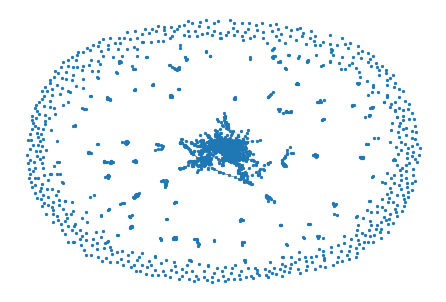

In [ ]:
pos=nx.spring_layout(G9)
nx.draw(G9,pos,node_size=5, width=0.1)

In [ ]:
#Degree Centrality
degree = dict(nx.degree(G9))
print_centrality(degree, 'Degree Centrality')

[('6304493681', 22), ('B000063UR0', 19), ('0790729628', 19), ('0780622553', 18), ('B00005R1O7', 17), ('B00005LKHZ', 17), ('B00005N5S5', 16), ('B00000IQW3', 16), ('B00006CXGG', 16), ('B00007AJG4', 16), ('B000067FP3', 15), ('B00008G96N', 14), ('B00008975H', 14), ('B00004RF9B', 13), ('0782009980', 13), ('0792160932', 12), ('6305744858', 12), ('B00004VVN8', 12), ('6305755035', 12), ('B000022TTQ', 12), ('1573623865', 11), ('B00003IXDZ', 11), ('6305078629', 11), ('6305744882', 11), ('6305971935', 11), ('B00005JKFR', 11), ('0767810864', 10), ('B000063UR2', 10), ('B000022TTL', 10), ('B00006SFIY', 10), ('B00005NVHT', 10), ('0790733226', 10), ('B00005R23R', 10), ('0790731479', 10), ('B0000648XE', 10), ('B00007JMD8', 10), ('6305754993', 10), ('B00004VVNB', 9), ('6305989397', 9), ('B00000IC1K', 9), ('B00005NG6A', 9), ('B00008PC2O', 9), ('B00005M91F', 9), ('B00005N5SE', 9), ('B00006LPC9', 9), ('B0000633TA', 9), ('B000056VOO', 9), ('B00005JKDR', 9), ('B00000K3D4', 9), ('6305869359', 9), ('B00003CXDD

ASIN  Degree Centrality
215   6304493681                 22
68    B000063UR0                 19
25    0790729628                 19
24    0780622553                 18
70    B00005R1O7                 17
...          ...                ...
1096  B00006LPF6                  0
1100  6305701512                  0
1104  B00005O074                  0
1106  6305772770                  0
1807  B000007SFG                  0

[1808 rows x 2 columns]

In [ ]:
#Betweenness centrality
betweenness = nx.betweenness_centrality(G9)
print_centrality(betweenness, 'Betweenness Centrality')

[('0790729628', 0.02653029870400751), ('B00004VVN8', 0.021970334846694802), ('B000062XG2', 0.021897629270840387), ('B00000IQW3', 0.020198866257973635), ('B00005JKFR', 0.0198108669500543), ('B00005LKHZ', 0.019759694986149007), ('B00003CXCZ', 0.018681731250093484), ('B00003CXBK', 0.0165353022973903), ('6304493681', 0.014913508935832605), ('630595027X', 0.014210234327970694), ('0790731479', 0.013633038161925), ('B000063UR2', 0.013493179584749715), ('6305558167', 0.011313603896972264), ('B00000K3TS', 0.011162273880250926), ('B000068MC4', 0.010234144154697736), ('0780622650', 0.01020884177237042), ('B000067FP3', 0.010142657556047686), ('B00007AJG4', 0.01004072467865746), ('B00003CXQM', 0.009786170680444874), ('6305971935', 0.009782325351152282), ('B00006CXGG', 0.009560983942519249), ('B00005N5S5', 0.009226767617069165), ('B00008OM8L', 0.009111002450947257), ('6305470316', 0.008349881758243376), ('B00003CXAT', 0.00832481202850738), ('630469654X', 0.008066754567258612), ('6305475822', 0.00761

ASIN  Betweenness Centrality
25    0790729628                0.026530
329   B00004VVN8                0.021970
1059  B000062XG2                0.021898
132   B00000IQW3                0.020199
616   B00005JKFR                0.019811
...          ...                     ...
861   B00005KH32                0.000000
859   B00005LO4I                0.000000
858   B00005Q304                0.000000
857   B00003ETIS                0.000000
1807  B000007SFG                0.000000

[1808 rows x 2 columns]

In [ ]:
#Closeness Centrality
closeness = nx.closeness_centrality(G9)
print_centrality(closeness, 'Closeness Centrality')

[('0790729628', 0.06275067702832283), ('B00004VVN8', 0.062402062155943266), ('0780622650', 0.060508946008881764), ('B00003CXIV', 0.059746655255690354), ('B00005ASUM', 0.059530000717803615), ('B00003CWU3', 0.05951340004833407), ('B00003CX44', 0.05918332018117747), ('6305475822', 0.05916691227427945), ('B0000844I8', 0.05911774309510415), ('0790733226', 0.058727312210601526), ('B00003CXXV', 0.05861440608990001), ('B00004W21Q', 0.058135399774809575), ('B00000IQW3', 0.05782038812607043), ('6305971935', 0.05782038812607043), ('B00005B8LW', 0.05778907462045112), ('B00000J2KP', 0.05778907462045112), ('B00005JKFR', 0.057415940966727454), ('6305558167', 0.05735421998745659), ('1573623865', 0.05729263156330898), ('0784011338', 0.05724652697782349), ('6305559279', 0.05724652697782349), ('6304490054', 0.05713923763676733), ('B00003CXQM', 0.05700188370014048), ('B00007L4N9', 0.05681976905573109), ('078322608X', 0.05675932249290584), ('0783226063', 0.05668394490659388), ('B00005R2IS', 0.0566839449065

ASIN  Closeness Centrality
25    0790729628              0.062751
329   B00004VVN8              0.062402
386   0780622650              0.060509
568   B00003CXIV              0.059747
456   B00005ASUM              0.059530
...          ...                   ...
1096  B00006LPF6              0.000000
1100  6305701512              0.000000
1104  B00005O074              0.000000
1106  6305772770              0.000000
1807  B000007SFG              0.000000

[1808 rows x 2 columns]

### Centrality merics for DVD category: Action

In [ ]:
df_action = amazon_dvd_df[amazon_dvd_df['categories'].str.contains('action')]
len(df_action)

3492

In [ ]:
dvd_action = {}
for key, value in amazon_dvd.items():
    if('action' in (value['categories'])):
        dvd_action[key] = amazon_dvd[key]

for key, value in dvd_action.items():
    dvd_action[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in dvd_action.keys()])

In [ ]:
# Transformation of comedy category of DVD data into graph
G10 = nx.Graph()
for key, value in dvd_action.items():
    G10.add_node(key)
    for i in value['connections'].split():
        G10.add_node(i.strip())
        similarity = 0
        try:
            set_1 = set(dvd_action[key]['categories'].split())
            set_2 = set(dvd_action[i]['categories'].split())
        except KeyError:
            continue
        union = set_1 & set_2
        intersection = set_1 | set_2
        if(len(union)) > 0:
            similarity = round(len(intersection)/len(union),2)
        G10.add_edge(key, i.strip(), weight=similarity)

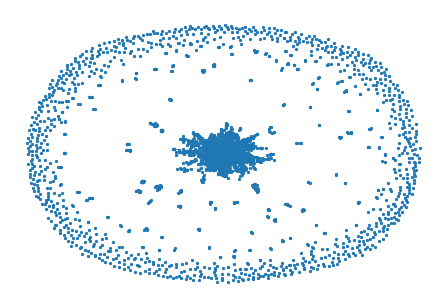

In [ ]:
pos=nx.spring_layout(G10)
nx.draw(G10,pos,node_size=5, width=0.1)

In [ ]:
#Degree Centrality
degree = dict(nx.degree(G10))
print_centrality(degree, 'Degree Centrality')

[('B00005ATZT', 37), ('B00004TJS2', 30), ('6305511705', 25), ('B0000507OK', 22), ('6304981635', 21), ('630580379X', 20), ('B00005N5S5', 20), ('B00004RF3N', 19), ('B00005KH39', 17), ('B00005UQ77', 17), ('B00004RF3O', 17), ('B00005NFZ1', 17), ('6305433852', 16), ('B0000541U5', 15), ('B000068DBC', 15), ('6305874905', 15), ('6305511667', 15), ('B00006FDCF', 14), ('B00005BCKB', 14), ('B00005U14C', 14), ('B00005K3LX', 14), ('1558908269', 14), ('B00005PJ8V', 14), ('6304711891', 14), ('B00006FDBE', 14), ('B00004W457', 13), ('B00005RDRS', 13), ('B00004STT7', 13), ('B000059PPI', 13), ('B00005YUNV', 13), ('0767803434', 13), ('6305433860', 13), ('B00005BCKD', 13), ('0783228465', 13), ('B00003W8NS', 13), ('B00004Z4WT', 13), ('B00005UQ76', 12), ('B00008K76V', 12), ('B00000JKWE', 12), ('630469623X', 12), ('B00000G3PA', 12), ('6304779607', 12), ('6304493681', 12), ('B00004XPPG', 12), ('B000068DBD', 12), ('B00008975Z', 12), ('B000051SH3', 12), ('B00004STDN', 12), ('0767821785', 12), ('B000056VOK', 11),

ASIN  Degree Centrality
76    B00005ATZT                 37
378   B00004TJS2                 30
760   6305511705                 25
269   B0000507OK                 22
112   6304981635                 21
...          ...                ...
2024  B00005BIFV                  0
2022  B000069HOX                  0
2021  B00005Y70T                  0
2020  6305186731                  0
1746  B00005UM3K                  0

[3492 rows x 2 columns]

In [ ]:
#Betweenness centrality
betweenness = nx.betweenness_centrality(G10)
print_centrality(betweenness, 'Betweenness Centrality')

[('B00003CXGG', 0.026377421985532015), ('B000059PPI', 0.022390867414756842), ('B00003W8NS', 0.021893477090052023), ('B00005ATZT', 0.020525305258281817), ('0780622650', 0.01829466188874028), ('0780621603', 0.018221726261460226), ('0790739739', 0.01712158176781919), ('B000092Q4V', 0.01406753944678476), ('B00005N5S5', 0.013968502170507508), ('B00005V1Y2', 0.012428258388986325), ('0783230362', 0.012421710458222816), ('B00003CXXV', 0.011575252228586592), ('6305475822', 0.0113055228621463), ('6304970471', 0.010981170875843908), ('6304981635', 0.01068242771830095), ('B000056VOK', 0.01068225513928462), ('0790738511', 0.010136668050543245), ('6305662355', 0.010129145253226873), ('B00000IQW3', 0.009981739192359866), ('B00005JKLZ', 0.0099070379168705), ('B00004RF9H', 0.009892596976887939), ('B00005K3LX', 0.009851930862299909), ('0767827678', 0.009847306827929917), ('0790731037', 0.009577106435176199), ('6304698526', 0.009464496018596039), ('0790736411', 0.009264478985165846), ('B00004YYDI', 0.009

ASIN  Betweenness Centrality
300   B00003CXGG                0.026377
312   B000059PPI                0.022391
246   B00003W8NS                0.021893
76    B00005ATZT                0.020525
438   0780622650                0.018295
...          ...                     ...
1644  6305176167                0.000000
1645  0784010226                0.000000
1646  B00004YS8Q                0.000000
1647  B00002CGG6                0.000000
1746  B00005UM3K                0.000000

[3492 rows x 2 columns]

In [ ]:
#Closeness Centrality
closeness = nx.closeness_centrality(G10)
print_centrality(closeness, 'Closeness Centrality')

[('B00005ATZT', 0.06206512007646514), ('0790739739', 0.059806118173620325), ('0790736411', 0.05950023581798602), ('0767803434', 0.05920951805340302), ('B00005N5S5', 0.05902925769805473), ('B00008K76X', 0.05884413812409017), ('B00005K3LX', 0.05843036718800917), ('B00005N5S8', 0.05841863064744715), ('B000059PPI', 0.05826648355771124), ('6304711891', 0.057602921901033007), ('B00004WMB7', 0.057178246864900355), ('0780621603', 0.05682077809481599), ('B00005NRNB', 0.056754249717692586), ('0790731894', 0.05662165923845335), ('B00005K3LU', 0.05659411416196062), ('630528069X', 0.05659411416196062), ('078323550X', 0.056522622228804914), ('B00006JMSU', 0.056511639498361146), ('6305428115', 0.05620041597648612), ('B000067G3C', 0.05611908397073143), ('B00004RFFY', 0.05598944127025039), ('B00004RFFX', 0.05587649427056977), ('B000062XGF', 0.05579074480688963), ('0790738511', 0.05569459070821824), ('6305106924', 0.055673268123720455), ('630460288X', 0.05558282898773352), ('0790732149', 0.0555403709879

ASIN  Closeness Centrality
76    B00005ATZT              0.062065
130   0790739739              0.059806
437   0790736411              0.059500
1112  0767803434              0.059210
681   B00005N5S5              0.059029
...          ...                   ...
2024  B00005BIFV              0.000000
2022  B000069HOX              0.000000
2021  B00005Y70T              0.000000
2020  6305186731              0.000000
1746  B00005UM3K              0.000000

[3492 rows x 2 columns]